# Machine Learning Project: Assessment 2

#### Option: 1

#### Your Student ID: 201802949

## 1. Aims, objectives and plan

### 1.1. Aims and Objectives

The primary aim of this project is to create a predictive model that can accurately determine the likelihood of a clinical trial being successful or unsuccessful. The model is built on a set of predefined success criteria that are critical for assessing and quantifying the outcome of clinical studies. This idea originated from my current workplace, FindMecure Ltd, a company that provides a consultation and feasibility platform for clinical trials. The platform serves clients in the pharmaceutical and clinical research industries, such as CROs and big pharma companies. This predictive model will allow stakeholders to better plan and evaluate clinical trials before significant resources are invested.

### 1.2. Plan

To conduct the project, I followed a structured approach that involved several key steps:

* __Data Collection__: I obtained the dataset from [FindMecure Ltd](https://www.findmecure.com/), which sources clinical trial data from publicly available databases such as [ClinicalTrials.gov](https://clinicaltrials.gov/) and [the Global Observatory on Health R&D (WHO)](https://www.who.int/observatories/global-observatory-on-health-research-and-development/resources/databases/databases-on-processes-for-r-d/clinical-trials).
* __Data Preprocessing and Exploration__: The data was cleaned and preprocessed to handle missing values, categorical features, and date fields.
* __Model Selection and Training__: Two machine learning models were selected: Logistic Regression and a Neural Network. These models were trained, optimized, and evaluated for the task at hand.
* __Model Evaluation__: The models were assessed on their predictive accuracy and interpretability, and the results were documented.

## 2. Understanding the case study

### Case Study Analysis

After thoroughly analyzing the dataset, I identified key challenges and planned specific steps to address them:

* 1. __Heterogeneous Data Types__: The dataset included numerical, categorical, and date-based features. Numerical features such as trial duration and enrollment counts required normalization, while categorical features like intervention model and trial status were one-hot encoded to be utilized effectively in our models. Date columns were converted to Unix timestamps to ensure consistency during model training.

* 2. __Missing Data__: Like most real-world datasets, there were missing values in several columns. For numerical features, missing values were imputed using the mean strategy, while categorical features were imputed with a constant value ('missing'). This approach ensured that the models did not face inconsistencies during training or predictions.

* 3. __Class Imbalance__: A significant imbalance was observed in the target variable, with fewer instances of successful clinical trials compared to unsuccessful ones. To handle this, I applied stratified sampling during the train-test split and cross-validation phases to maintain the class distribution across subsets. Additionally, oversampling or class-weight adjustments were applied to models as necessary to counteract bias.

* 4. __Feature Selection and Importance__: Several columns had multi-categorical lists, such as the therapeutic areas and conditions columns, which required special handling. I applied keyword matching techniques to create enriched features based on relevant medical terms, improving the depth and relevance of the features used by the models. Furthermore, after training, I used logistic regression coefficients and neural network feature importances to gain insights into which factors contributed most significantly to clinical trial success.

By addressing these key points, I ensured that the dataset was preprocessed effectively and structured in a way that maximized the models’ performance and interpretability. Through this project, I aimed to balance predictive accuracy with practical insights to help stakeholders make better-informed decisions about clinical trial feasibility.

## 3. Dataset description

### 3.1. Data Overview

I explored key features such as trial status, the number of participants, study design characteristics, gender distribution, and whether or not the trials exceeded expectations. The aim was to better understand how each of these factors could contribute to predicting trial success. Here’s an example of a few entries from our dataset:

* __Number of Samples__: Approximately 325,000 trials.
* __Features__: Over 30 columns, including numeric (like plannedEnrollment), categorical (like masking), and textual features (like officialTitle).

### 3.2. Preprocessing Steps

To prepare the data for analysis, I performed several preprocessing tasks:

* Type convertion-from __json__ to __ndjson__. This is done for faster batch loading of the datasets and faster batch processing in the __csv__ convertion.
* Type convertion-from __ndjson__ to __csv__. This is done for easier interpretability and feeding into dataframes.
* Data enrichment: Adding new columns through feature engineering and matching between conditions column in trials dataset and entryTerms in conditions dataset.
* Imputation: Filled missing numeric and categorical values based on context( by averaging similar trials based on grouping criteria).
* Date Conversion: Converted date columns such as startDate to Unix timestamps to handle them numerically.
* Encoding: One-hot encoded categorical features to allow their use in machine learning models.
* Normalization: Standardized numeric features to ensure consistency across the dataset.

## 4. Data Preparation

### 4.1. '__json_to_ndjson__' function converts initial '__json__' files to '__ndjson__' for easier batch reading.

### 4.1.0. Imports

In [43]:
import json
import csv
from datetime import datetime
from mtranslate import translate
import logging
import os
from tqdm import tqdm 
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing
import pandas as pd

### 4.1.1. Defining a function that converst files from __json__ to __ndjson__ format.

In [44]:
def json_to_ndjson(input_file, output_file):
    with open(input_file, 'r', encoding='utf-8') as json_file:
        data = json.load(json_file)
    
    with open(output_file, 'w', encoding='utf-8') as ndjson_file:
        for item in data:
            ndjson_file.write(json.dumps(item) + '\n')


#### 4.1.2. Convert '__FmcDb.clinicalTrials2.json__' to '__FmcDb.clinicalTrials2.ndjson__'

In [ ]:
json_to_ndjson("json/FmcDb.clinicalTrials2.json", "ndjson/FmcDb.clinicalTrials2.ndjson")

#### 4.1.3. Convert '__FmcDb.clinicalTrialsBg.json__' to '__FmcDb.clinicalTrialsBg.ndjson__'

In [6]:
json_to_ndjson("json/FmcDb.clinicalTrialsBg.json", "ndjson/FmcDb.clinicalTrialsBg.ndjson" )

#### 4.1.4. Convert '__FmcDb.conditions.json__' to '__FmcDb.conditions.ndjson__'

In [7]:
json_to_ndjson("json/FmcDb.conditions.json", "ndjson/FmcDb.conditions.ndjson")

### 4.2. Extract the important features from the '__ndjson__' files in batches and convert them to '__csv__' format.

#### 4.2.1. Define extraction and conversion functions for '__FmcDb.clinicalTrials2.ndjson__' and '__FmcDb.clinicalTrialsBg.ndjson__'.

In [25]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def translate_text(text, src_lang='bg', dest_lang='en'):
    try:
        translated = translate(text, dest_lang, src_lang)
        return translated
    except Exception as e:
        print(f"Error translating text: {text}. Error: {e}")
        return text 

def calculate_trial_duration(start_date_str, end_date_str):
    try:
        start_date = datetime.strptime(start_date_str[:10], '%Y-%m-%d')
        end_date = datetime.strptime(end_date_str[:10], '%Y-%m-%d')
        return (end_date - start_date).days
    except Exception:
        return 'N/A'

def calculate_ARR(actual_enrollment, start_date, end_date):
    try:
        timeline_days = calculate_trial_duration(start_date, end_date)
        if timeline_days == 'N/A' or timeline_days == 0:
            return 'N/A'
        return round(actual_enrollment / timeline_days, 2)
    except Exception:
        return 'N/A'

def label_trial_status(planned_enrollment, actual_enrollment, planned_end_date, actual_end_date, trial_duration, planned_trial_duration):
    """Label the trial as successful, failed, return is_delayed and exceeded_expectations flag."""
    if pd.isna(planned_enrollment) or pd.isna(actual_enrollment) or pd.isna(planned_end_date) or pd.isna(actual_end_date) or pd.isna(trial_duration) or pd.isna(planned_trial_duration):
        return 'N/A', 0, 0

    is_delayed = 0
    exceeded_expectations = 0

    try:
        actual_end_date_parsed = datetime.strptime(actual_end_date[:10], '%Y-%m-%d')
        planned_end_date_parsed = datetime.strptime(planned_end_date[:10], '%Y-%m-%d')
    except Exception:
        return 'N/A', 0, 0
    
    if actual_end_date_parsed < planned_end_date_parsed and planned_enrollment == actual_enrollment and trial_duration < planned_trial_duration:
        exceeded_expectations = 1
        return 'Successful', 0, exceeded_expectations
        
    if actual_enrollment == planned_enrollment and trial_duration > planned_trial_duration and actual_end_date_parsed > planned_end_date_parsed:
        is_delayed = 1
        return 'Successful', is_delayed, 0

    if planned_enrollment == actual_enrollment and planned_end_date_parsed == actual_end_date_parsed and trial_duration == planned_trial_duration:
        return 'Successful', 0, 0
    
    if actual_enrollment != planned_enrollment and trial_duration > planned_trial_duration and actual_end_date_parsed > planned_end_date_parsed:
        is_delayed = 1
        return 'Failed', is_delayed, 0
    
    if actual_enrollment != planned_enrollment and trial_duration != planned_trial_duration and actual_end_date_parsed != planned_end_date_parsed:
        return 'Failed', 0, 0
    
    return 'Failed', 0, 0

def process_ndjson_in_batches(input_file, output_file, batch_size=100, translate=False):
    with open(output_file, 'w', newline='', encoding='utf-8') as csv_file:
        writer = csv.writer(csv_file)
        important_fields = [
            'nctId', 'officialTitle', 'phase', 'studyType', 
            'plannedEnrollment', 'actualEnrollment', 'countriesCount', 
            'sitesCount', 'countries', 'startDate', 'plannedCompletionDate', 
            'actualCompletionDate', 'trialDuration', 'plannedTrialDuration', 'ARR',
            'interventionModel', 'allocation', 'masking', 'numberOfArms',
            'fdaRegulated', 'minAge', 'maxAge', 'gender', 'interventionType', 
            'conditions', 'primaryOutcomesCount', 'secondaryOutcomesCount',
            'overallStatus', 'lastKnownStatus', 'trialStatus', 'is_delayed', 'exceededExpectations'
        ]
        writer.writerow(important_fields)
        
        with open(input_file, 'r', encoding='utf-8') as json_file:
            batch = []
            for line in json_file:
                try:
                    trial = json.loads(line.strip())
                    if trial is not None:
                        overall_status = trial.get('overallStatus', 'N/A')
                        if overall_status in [5, 6, 7, 8, 14]:
                            batch.append(trial)
                except json.JSONDecodeError:
                    continue
                
                if len(batch) >= batch_size:
                    write_batch_to_csv(batch, writer, translate)
                    batch = []
            
            if batch:
                write_batch_to_csv(batch, writer, translate)

def write_batch_to_csv(batch, writer, translate):
    for trial in batch:
        actual_performance = trial.get('actualPerformance', {}) or {}
        planned_performance = trial.get('plannedPerformance', {}) or {}
        study_design_info = trial.get('studyDesignInfo', {}) or {}
        eligibility = trial.get('eligibility', {}) or {}
        oversight_info = trial.get('oversightInfo', {}) or {}
        id_info = trial.get('idInfo', {}) or {}

        actual_end_date = actual_performance.get('completionDate', {}).get('$date', 'N/A')
        start_date = planned_performance.get('startDate', {}).get('$date', 'N/A')
        planned_end_date = planned_performance.get('completionDate', {}).get('$date', 'N/A')
        
        planned_trial_duration = calculate_trial_duration(start_date, planned_end_date)
        actual_trial_duration = calculate_trial_duration(start_date, actual_end_date)
        actual_enrollment = actual_performance.get('enrollment', 'N/A')
        arr = calculate_ARR(actual_enrollment, start_date, actual_end_date)

        interventions = ', '.join([str(intervention.get('type', 'N/A')) for intervention in trial.get('interventions', [])])
        conditions = ', '.join([str(condition) for condition in trial.get('conditions', [])])
        
        countries_list = trial.get('locationCountries', [])
        countries = ', '.join(countries_list)

        official_title = trial.get('officialTitle', 'N/A')
        if translate:
            official_title = translate_text(official_title)

        conditions_translated = conditions
        if translate:
            conditions_translated = translate_text(conditions)

        planned_enrollment = planned_performance.get('enrollment', 'N/A')
        trial_status, is_delayed, exceeded_expectations = label_trial_status(
            planned_enrollment, actual_enrollment, planned_end_date, actual_end_date, 
            actual_trial_duration, planned_trial_duration
        )

        row = [
            id_info.get('nctId', 'N/A'),
            official_title,
            trial.get('phase', 'N/A'),
            trial.get('studyType', 'N/A'),
            planned_enrollment,
            actual_enrollment,
            planned_performance.get('countriesCount', 'N/A'),
            planned_performance.get('sitesCount', 'N/A'),
            countries,
            start_date,
            planned_end_date,
            actual_end_date,
            actual_trial_duration,
            planned_trial_duration,
            arr,
            study_design_info.get('interventionModel', 'N/A'),
            study_design_info.get('allocation', 'N/A'),
            study_design_info.get('masking', 'N/A'),
            trial.get('numberOfArms', 'N/A'),
            oversight_info.get('isFdaRegulatedDrug', 'N/A'),
            eligibility.get('minAge', 'N/A'),
            eligibility.get('maxAge', 'N/A'),
            eligibility.get('genderEnum', 'N/A'),
            interventions,
            conditions_translated,
            len(trial.get('primaryOutcomes', [])),
            len(trial.get('secondaryOutcomes', [])),
            trial.get('overallStatus', 'N/A'),
            trial.get('lastKnownStatus', 'N/A'),
            trial_status,
            is_delayed, 
            exceeded_expectations
        ]
        
        writer.writerow(row)


#### 4.2.2. Extract important features from '__FmcDb.clinicalTrials2.ndjson__' and convert them to '__completed_clinical_trials.csv__'.

In [26]:
process_ndjson_in_batches("ndjson/FmcDb.clinicalTrials2.ndjson", "csv/completed_clinical_trials.csv", batch_size=100)

#### 4.2.3. Extract important features from '__FmcDb.clinicalTrialsBg.ndjson__' and convert them to '__completed_clinical_trials_bg.csv__'.

In [27]:
process_ndjson_in_batches("ndjson/FmcDb.clinicalTrialsBg.ndjson", "csv/completed_clinical_trials_bg.csv", batch_size=100, translate=True)

Error translating text: Международно, двойно-сляпо, рандомизирано, контролирано от плацебо изпитване фаза IIb за оценка на ефикасността, безопасността и фармакокинетиката на GNbAC1 при пациенти с рецидивираща ремитираща множествена склероза. Error: <urlopen error [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond>


#### 4.2.4. Extract important features from '__FmcDb.conditions.ndjson__' and convert them to '__conditions.csv__'.

In [28]:
def conditions_ndjson_to_csv(input_file, output_file, batch_size=100):
    with open(output_file, 'w', newline='', encoding='utf-8') as csv_file:
        writer = csv.writer(csv_file)

        headers = ['condition', 'meshId', 'therapeuticArea', 'entryTerms', 'treatedByDrugs']
        writer.writerow(headers)

        with open(input_file, 'r', encoding='utf-8') as ndjson_file:
            batch = []
            for line in ndjson_file:
                try:
                    record = json.loads(line.strip())
                    if record is not None:
                        batch.append(record)
                except json.JSONDecodeError:
                    continue

                if len(batch) >= batch_size:
                    write_conditions_batch_to_csv(batch, writer)
                    batch = []

            if batch:
                write_conditions_batch_to_csv(batch, writer)

def write_conditions_batch_to_csv(batch, writer):
    for record in batch:
        row = [
            record.get('condition', 'N/A'),
            record.get('meshId', 'N/A'),
            record.get('therapeuticArea', 'N/A'),
            handle_entry_terms(record.get('entryTerms')),  
            extract_treated_by_drugs(record.get('treatedByDrugs', [])) 
        ]
        writer.writerow(row)

def handle_entry_terms(entry_terms):
    if not entry_terms: 
        return 'N/A'
    if isinstance(entry_terms, list):
        return ', '.join(entry_terms)
    return str(entry_terms) 

def extract_treated_by_drugs(treated_by_drugs):
    if not treated_by_drugs:
        return 'N/A'
    
    drugs_list = []
    for drug in treated_by_drugs:
        if isinstance(drug, dict):
            drug_name = drug.get('name', 'N/A')
            trade_names = ', '.join(drug.get('tradeNames', []))
            if trade_names:
                drugs_list.append(f"{drug_name} ({trade_names})")
            else:
                drugs_list.append(drug_name)
        else:
            drugs_list.append(str(drug))
    
    return '; '.join(drugs_list)

#### 4.2.3. Extract important features from '__FmcDb.conditions.ndjson__' and convert them to '__conditions.csv__'.

In [31]:
conditions_ndjson_to_csv('ndjson/FmcDb.conditions.ndjson', 'csv/conditions.csv')

### 4.3. Perform operations on the '__csv__' data.

#### 4.3.0. Imports

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import os
from tqdm import tqdm

#### 4.3.1. Load the Datasets

In [3]:
completed_trials_bg_df = pd.read_csv('csv/completed_clinical_trials_bg.csv')
completed_trials_df = pd.read_csv('csv/completed_clinical_trials.csv')
conditions_df = pd.read_csv('csv/conditions.csv')

C:\Users\trail\AppData\Local\Temp\ipykernel_25584\1988498280.py:2: DtypeWarning: Columns (11,29) have mixed types. Specify dtype option on import or set low_memory=False.
  completed_trials_df = pd.read_csv('csv/completed_clinical_trials.csv')


#### 4.3.2. Show the structure of the datasets I will be working with.

In [34]:
print("\nCompleted Clinical Trials (EN):")
display(completed_trials_df.head())

print("\nCompleted Clinical Trials (BG):")
display(completed_trials_bg_df.head())

print("\nConditions:")
display(conditions_df.head())


Completed Clinical Trials (EN):


,nctId,officialTitle,phase,studyType,plannedEnrollment,actualEnrollment,countriesCount,sitesCount,countries,startDate,...,gender,interventionType,conditions,primaryOutcomesCount,secondaryOutcomesCount,overallStatus,lastKnownStatus,trialStatus,is_delayed,exceededExpectations
0,NCT04269499,Real-time MR Imaged Treatment With Holmium Mic...,0,1,6.0,6.0,1.0,1.0,Netherlands,2019-11-10T22:00:00.000Z,...,2.0,3,"Liver Cancer, Liver Metastases",1,4,5,0,Successful,1,0
1,NCT04269460,Comparison of Ultrasound Guided Subcostal Tran...,0,1,78.0,78.0,1.0,1.0,Egypt,2020-01-31T22:00:00.000Z,...,2.0,6,"Pain Management, Pediatrics, Anesthesia",1,3,5,0,Successful,1,0
2,NCT04269434,Does Screening for Gonorrhea and Chlamydia Aff...,0,1,1014.0,1014.0,1.0,5.0,Belgium,2020-09-20T21:00:00.000Z,...,0.0,10,"Neisseria Gonorrhoeae Infection, Chlamydia Tra...",1,6,5,0,Successful,0,1
3,NCT04269421,Return To Sport Activities in Patients Surgica...,0,4,NaN,NaN,NaN,NaN,Italy,NaN,...,2.0,8,"Flat Feet, Surgery, Sports Physical Therapy",1,1,5,0,NaN,0,0
4,NCT04269408,"A Phase IIb: Randomised, Single-Blind, Safety,...",4,1,NaN,NaN,NaN,NaN,"Austria, Germany",NaN,...,2.0,"6, 10",Aneurysmal Subarachnoid Hemorrhage,2,1,5,0,NaN,0,0



Completed Clinical Trials (BG):


,nctId,officialTitle,phase,studyType,plannedEnrollment,actualEnrollment,countriesCount,sitesCount,countries,startDate,...,gender,interventionType,conditions,primaryOutcomesCount,secondaryOutcomesCount,overallStatus,lastKnownStatus,trialStatus,is_delayed,exceededExpectations
0,NCT02992288,"A multicenter, randomized, placebo-controlled,...",4,1,NaN,NaN,NaN,NaN,"Belgium, Bulgaria, Germany, Greece, Israel, It...",NaN,...,2,"6, 6, 6, 6, 6, 6",Heart failure,2,6,5,0,NaN,0,0
1,NCT02906930,Efficacy and safety of oral semaglutide versus...,6,1,NaN,NaN,NaN,NaN,"Algeria, Bulgaria, Czechia, Italy, Japan, Mexi...",NaN,...,2,"6, 6","Diabetes, Type 2 diabetes",1,47,5,0,NaN,0,0
2,NCT02878330,"A Phase 2b, Randomized, Double-Blind, Placebo-...",4,1,NaN,NaN,NaN,NaN,"Argentina, Australia, Belgium, Brazil, Bulgari...",NaN,...,2,"6, 6",Respiratory syncytial virus infections,1,6,5,0,NaN,0,0
3,NCT02847598,"A randomized, double-blind, placebo-controlled...",4,1,NaN,NaN,NaN,NaN,"Argentina, Bulgaria, Colombia, Israel, Korea, ...",NaN,...,2,"6, 6","Systemic lupus erythematosus, Active cutaneous...",2,34,5,0,NaN,0,0
4,NCT03002233,A phase 1 study to observe the safety and tole...,2,1,NaN,NaN,NaN,NaN,"Bulgaria, Germany",NaN,...,2,6,Uremic pruritus,12,0,5,0,NaN,0,0



Conditions:


,condition,meshId,therapeuticArea,entryTerms,treatedByDrugs
0,Infections,D007239,Infections,"Infection, Infection and Infestation, Infectio...",NaN
1,"Arthritis, Infectious",D001170,Infections,"Arthritides, Bacterial, Arthritis, Bacterial, ...","cilastatin (Primaxin, Recarbrio); cilastatin s..."
2,Asymptomatic Infections,D058345,Infections,"Asymptomatic Colonization, Asymptomatic Infect...",NaN
3,"Aneurysm, Infected",D000785,Infections,"Aneurysm, Bacterial, Aneurysm, Infected, Aneur...",NaN
4,"Bone Diseases, Infectious",D001850,Infections,"Bone Diseases, Infectious","amikacin (Amikin, Amimax, Arikayce); amikacin ..."


#### 4.3.3. Merge Clinical Trials (English and Bulgarian)

In [35]:
combined_trials_df = pd.concat([completed_trials_df, completed_trials_bg_df], ignore_index=True)

combined_trials_df.to_csv(os.path.join('data', 'combined_clinical_trials.csv'), index=False)

combined_trials_df.head()

,nctId,officialTitle,phase,studyType,plannedEnrollment,actualEnrollment,countriesCount,sitesCount,countries,startDate,...,gender,interventionType,conditions,primaryOutcomesCount,secondaryOutcomesCount,overallStatus,lastKnownStatus,trialStatus,is_delayed,exceededExpectations
0,NCT04269499,Real-time MR Imaged Treatment With Holmium Mic...,0,1,6.0,6.0,1.0,1.0,Netherlands,2019-11-10T22:00:00.000Z,...,2.0,3,"Liver Cancer, Liver Metastases",1,4,5,0,Successful,1,0
1,NCT04269460,Comparison of Ultrasound Guided Subcostal Tran...,0,1,78.0,78.0,1.0,1.0,Egypt,2020-01-31T22:00:00.000Z,...,2.0,6,"Pain Management, Pediatrics, Anesthesia",1,3,5,0,Successful,1,0
2,NCT04269434,Does Screening for Gonorrhea and Chlamydia Aff...,0,1,1014.0,1014.0,1.0,5.0,Belgium,2020-09-20T21:00:00.000Z,...,0.0,10,"Neisseria Gonorrhoeae Infection, Chlamydia Tra...",1,6,5,0,Successful,0,1
3,NCT04269421,Return To Sport Activities in Patients Surgica...,0,4,NaN,NaN,NaN,NaN,Italy,NaN,...,2.0,8,"Flat Feet, Surgery, Sports Physical Therapy",1,1,5,0,NaN,0,0
4,NCT04269408,"A Phase IIb: Randomised, Single-Blind, Safety,...",4,1,NaN,NaN,NaN,NaN,"Austria, Germany",NaN,...,2.0,"6, 10",Aneurysmal Subarachnoid Hemorrhage,2,1,5,0,NaN,0,0


#### 4.3.4. Load the combined trials

In [4]:
combined_trials_df = pd.read_csv('data/combined_clinical_trials.csv')

C:\Users\trail\AppData\Local\Temp\ipykernel_36264\3388863587.py:1: DtypeWarning: Columns (11,29) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_trials_df = pd.read_csv('data/combined_clinical_trials.csv')


In [3]:
import dask.dataframe as dd
import re
import logging
from dask.diagnostics import ProgressBar
import multiprocessing

#### 4.3.5. Enrich clinical trials with therapeuticAreas

In [10]:
combined_trials_df['therapeuticAreas'] = pd.NA

def enrich_therapeutic_areas(row, conditions_df):
    conditions = row['conditions']
    therapeutic_areas = set()
    
    if pd.notna(conditions):
        condition_list = [cond.strip() for cond in conditions.split(',')]
        
        for cond in condition_list:
            cond_escaped = re.escape(cond)
            matches = conditions_df[
                conditions_df['entryTerms'].str.contains(cond_escaped, case=False, na=False)
            ]
            
            therapeutic_areas.update(matches['therapeuticArea'].dropna().tolist())
    
    row['therapeuticAreas'] = ', '.join(therapeutic_areas) if therapeutic_areas else pd.NA
    return row

ddf_combined_trials = dd.from_pandas(combined_trials_df, npartitions=multiprocessing.cpu_count())

def process_partition(df_part, conditions_df):
    return df_part.apply(lambda row: enrich_therapeutic_areas(row, conditions_df), axis=1)

ddf_combined_trials = ddf_combined_trials.map_partitions(lambda df: process_partition(df, conditions_df))

with ProgressBar():
    enriched_trials_df = ddf_combined_trials.compute()

enriched_trials_df.to_csv('data/enriched_clinical_trials.csv', index=False)

print("Therapeutic areas enrichment completed.")

[#########                               ] | 24% Completed | 2hr 19ms

C:\Users\trail\AppData\Local\Temp\ipykernel_36264\2606147033.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['therapeuticAreas'] = ', '.join(therapeutic_areas) if therapeutic_areas else pd.NA
C:\Users\trail\AppData\Local\Temp\ipykernel_36264\2606147033.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['therapeuticAreas'] = ', '.join(therapeutic_areas) if therapeutic_areas else pd.NA


[########################################] | 100% Completed | 2hr 35m
Therapeutic areas enrichment completed.


#### 4.3.6. Function that converts date columns to datetime

In [11]:
def convert_date_columns(df):
    date_columns = ['startDate', 'plannedCompletionDate', 'actualCompletionDate']

    for col in date_columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
    
    return df

#### 4.3.7. Load enriched_clinical_trials.csv

In [12]:
enriched_trials_df = pd.read_csv('data/enriched_clinical_trials.csv')

C:\Users\trail\AppData\Local\Temp\ipykernel_36264\1857125818.py:1: DtypeWarning: Columns (11,29) have mixed types. Specify dtype option on import or set low_memory=False.
  enriched_trials_df = pd.read_csv('data/enriched_clinical_trials.csv')


#### 4.3.8. Convert date columns to datetime in enriched_trials_df

In [13]:
enriched_trials_df = convert_date_columns(enriched_trials_df)

#### 4.3.9. Save The date changes in the file

In [14]:
enriched_trials_df.to_csv('data/enriched_clinical_trials.csv', index=False)

#### 4.3.10. Group entries by criteria and fill the missing values based on the groups

In [30]:
import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import logging
from time import time
import psutil

logging.basicConfig(filename='data_processing_fallback.log', level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

def process_therapeutic_areas(areas_str):
    if pd.isna(areas_str) or areas_str == "":
        return []
    return [x.strip() for x in areas_str.split(',')]

def list_similarity(list1, list2):
    if not list1 or not list2:
        return 0
    matches = len(set(list1) & set(list2))
    total_elements = len(set(list1) | set(list2))
    return matches / total_elements if total_elements else 0

def fill_missing_for_row(row, group):
    for col in group.columns:
        if col == 'therapeuticAreas_processed':
            if not row[col]:
                best_match = None
                best_similarity = -1
                for _, group_row in group.iterrows():
                    sim = list_similarity(row['therapeuticAreas_processed'], group_row['therapeuticAreas_processed'])
                    if sim > best_similarity:
                        best_similarity = sim
                        best_match = group_row
                if best_match is not None:
                    row['therapeuticAreas_processed'] = best_match['therapeuticAreas_processed']
        elif pd.isna(row[col]):
            if pd.api.types.is_numeric_dtype(group[col]):
                if group[col].notna().any():
                    row[col] = group[col].mean()
            else:
                criteria_list = [
                    ['interventionModel', 'allocation', 'trialStatus'],
                    ['interventionModel', 'trialStatus'],
                    ['trialStatus'],
                ]
                best_match = None
                best_similarity = -1
                
                for criteria in criteria_list:
                    for _, group_row in group.iterrows():
                        sim = sum(row[c] == group_row[c] for c in criteria) 
                        sim += list_similarity(row['therapeuticAreas_processed'], group_row['therapeuticAreas_processed'])
                        
                        if sim > best_similarity:
                            best_similarity = sim
                            best_match = group_row
                    if best_match is not None:
                        break 

                if best_match is not None:
                    row[col] = best_match[col]
    return row

def process_group(group, group_index, total_groups):
    processed_rows = []
    for idx, row in group.iterrows():
        processed_row = fill_missing_for_row(row, group)
        processed_rows.append(processed_row)
    
    logging.info(f"Processed group {group_index + 1}/{total_groups} with {len(group)} rows.")
    return pd.DataFrame(processed_rows, columns=group.columns)

def process_group_wrapper(grouped_group, group_index, total_groups):
    _, group = grouped_group
    return process_group(group, group_index, total_groups)

def log_system_resources():
    cpu_percent = psutil.cpu_percent()
    memory_info = psutil.virtual_memory()
    logging.info(f"CPU Usage: {cpu_percent}% | Memory Usage: {memory_info.percent}%")

def fill_missing_values(df, num_workers=4, chunksize=10):
    df.loc[:, 'therapeuticAreas_processed'] = df['therapeuticAreas'].apply(process_therapeutic_areas)
    grouping_cols = ['interventionModel', 'allocation', 'trialStatus']
    grouped = list(df.groupby(grouping_cols))

    total_groups = len(grouped)
    logging.info(f"Starting to process {total_groups} groups.")

    start_time = time()

    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        results = list(executor.map(
            lambda group_idx: process_group_wrapper(group_idx[1], group_idx[0], total_groups), 
            enumerate(grouped), 
            chunksize=chunksize
        ))

    if results:
        filled_df = pd.concat(results, ignore_index=True)
    else:
        filled_df = df 

    elapsed_time = time() - start_time
    logging.info(f"Processing completed in {elapsed_time / 60:.2f} minutes.")
    
    return filled_df

def process_in_batches(filename, output_file, chunksize=1000, num_workers=24):
    chunk_num = 0
    start_time = time()

    with pd.read_csv(filename, chunksize=chunksize) as reader:
        for chunk in reader:
            chunk_num += 1
            logging.info(f"Processing chunk {chunk_num} with {len(chunk)} rows.")

            filled_chunk = fill_missing_values(chunk, num_workers=num_workers)

            if chunk_num == 1:
                filled_chunk.to_csv(output_file, index=False, mode='w')
            else:
                filled_chunk.to_csv(output_file, index=False, mode='a', header=False)

            logging.info(f"Finished processing chunk {chunk_num}. Elapsed time: {(time() - start_time) / 60:.2f} minutes.")
            log_system_resources()

    logging.info("All chunks processed.")

process_in_batches('data/enriched_clinical_trials.csv', 'data/enriched_clinical_trials_filled_fallback.csv', chunksize=1000, num_workers=32)


2024-10-24 00:03:10,630 - INFO - Processing chunk 1 with 1000 rows.
2024-10-24 00:03:10,636 - INFO - Starting to process 19 groups.
2024-10-24 00:03:10,638 - INFO - Processed group 1/19 with 1 rows.
2024-10-24 00:03:10,641 - INFO - Processed group 2/19 with 1 rows.


2024-10-24 00:03:10,647 - INFO - Processed group 3/19 with 15 rows.
2024-10-24 00:03:10,649 - INFO - Processed group 5/19 with 1 rows.
2024-10-24 00:03:10,650 - INFO - Processed group 6/19 with 1 rows.
2024-10-24 00:03:10,652 - INFO - Processed group 7/19 with 3 rows.
2024-10-24 00:03:10,659 - INFO - Processed group 9/19 with 7 rows.
2024-10-24 00:03:10,667 - INFO - Processed group 8/19 with 11 rows.
2024-10-24 00:03:10,672 - INFO - Processed group 4/19 with 13 rows.
2024-10-24 00:03:10,675 - INFO - Processed group 12/19 with 1 rows.
2024-10-24 00:03:10,675 - INFO - Processed group 13/19 with 1 rows.
2024-10-24 00:03:10,697 - INFO - Processed group 17/19 with 1 rows.
2024-10-24 00:03:10,731 - INFO - Processed group 18/19 with 1 rows.
2024-10-24 00:03:10,735 - INFO - Processed group 16/19 with 1 rows.
2024-10-24 00:03:10,736 - INFO - Processed group 14/19 with 4 rows.
2024-10-24 00:03:10,745 - INFO - Processed group 19/19 with 2 rows.
2024-10-24 00:03:10,749 - INFO - Processed group 15/

#### 4.3.11. Load the Eniched clinical trials with filled missing values based on groups.

In [4]:
enriched_trials_filled_df = pd.read_csv('data/enriched_clinical_trials_filled_fallback.csv')

C:\Users\trail\AppData\Local\Temp\ipykernel_41236\908012823.py:1: DtypeWarning: Columns (11,29) have mixed types. Specify dtype option on import or set low_memory=False.
  enriched_trials_filled_df = pd.read_csv('data/enriched_clinical_trials_filled_fallback.csv')


#### 4.3.12. Define function for recalculating __trialStatus__, __trialDuration__ and __ARR__ in the filled dataset.

In [96]:
def calculate_trial_duration(start_date, end_date):
    """Calculate the duration between two datetime objects in days."""
    try:
        if pd.isnull(start_date) or pd.isnull(end_date):
            return np.nan
        return (end_date - start_date).days
    except Exception as e:
        print(f"Error calculating trial duration: {e}")
        return np.nan

def calculate_ARR(actual_enrollment, start_date, end_date):
    """Calculate ARR as actual enrollment divided by the number of days between start and end dates."""
    try:
        timeline_days = calculate_trial_duration(start_date, end_date)
        if np.isnan(timeline_days) or timeline_days == 0:
            return np.nan
        return round(actual_enrollment / timeline_days, 2)
    except Exception as e:
        print(f"Error calculating ARR: {e}")
        return np.nan

def label_trial_status(planned_enrollment, actual_enrollment, planned_end_date, actual_end_date, trial_duration, planned_trial_duration):
    """Label the trial based on various criteria and return trial status, is_delayed flag, and exceeded_expectations flag."""
    try:
        if pd.isnull([planned_enrollment, actual_enrollment, planned_end_date, actual_end_date, trial_duration, planned_trial_duration]).any():
            return 'N/A', 0, 0

        is_delayed = 0
        exceeded_expectations = 0

        if actual_end_date < planned_end_date and planned_enrollment == actual_enrollment and trial_duration < planned_trial_duration:
            exceeded_expectations = 1
            return 'Successful', 0, exceeded_expectations

        if actual_enrollment == planned_enrollment and trial_duration > planned_trial_duration and actual_end_date > planned_end_date:
            is_delayed = 1
            return 'Successful', is_delayed, 0

        if planned_enrollment == actual_enrollment and planned_end_date == actual_end_date and trial_duration == planned_trial_duration:
            return 'Successful', 0, 0

        if actual_enrollment != planned_enrollment and trial_duration > planned_trial_duration and actual_end_date > planned_end_date:
            is_delayed = 1
            return 'Failed', is_delayed, 0

        return 'Failed', 0, 0
    except Exception as e:
        print(f"Error labeling trial status: {e}")
        return 'N/A', 0, 0

#### 4.3.13. Fill missing numeric values with mean (excluding specified columns)

In [97]:
exclude_cols = ['trialDuration', 'plannedTrialDuration', 'ARR', 'trialStatus', 'is_delayed', 'exceededExpectations']
numeric_cols = enriched_trials_filled_df.select_dtypes(include=[np.number]).columns.tolist()
cols_to_fill = [col for col in numeric_cols if col not in exclude_cols]

for col in cols_to_fill:
    mean_val = enriched_trials_filled_df[col].mean()
    enriched_trials_filled_df[col] = enriched_trials_filled_df[col].fillna(mean_val).round(1)

#### 4.3.14. Fill missing categorical values with mode

In [98]:
categorical_cols = enriched_trials_filled_df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    mode_val = enriched_trials_filled_df[col].mode()[0]
    enriched_trials_filled_df[col] = enriched_trials_filled_df[col].fillna(mode_val)

#### 4.3.15. Fill missing datetime columns with median date

In [99]:
date_columns = ['startDate', 'plannedCompletionDate', 'actualCompletionDate']
for col in date_columns:
    enriched_trials_filled_df[col] = pd.to_datetime(enriched_trials_filled_df[col], errors='coerce')
    median_date = enriched_trials_filled_df[col].dropna().median()
    enriched_trials_filled_df[col] = enriched_trials_filled_df[col].fillna(median_date)

#### 4.3.16. Validate and fix `minAge` and `maxAge`

In [100]:
min_age_mean = enriched_trials_filled_df['minAge'].mean()
max_age_mean = enriched_trials_filled_df['maxAge'].mean()

enriched_trials_filled_df['minAge'] = enriched_trials_filled_df['minAge'].apply(lambda x: min_age_mean if pd.isna(x) or x <= 0 else x)
enriched_trials_filled_df['maxAge'] = enriched_trials_filled_df['maxAge'].apply(lambda x: max_age_mean if pd.isna(x) or x <= 0 else x)

enriched_trials_filled_df.loc[enriched_trials_filled_df['minAge'] > enriched_trials_filled_df['maxAge'], 'maxAge'] = \
    enriched_trials_filled_df['minAge'] + 1

#### 4.3.17. Recalculate specific columns

In [101]:
for index, row in enriched_trials_filled_df.iterrows():
    enriched_trials_filled_df.at[index, 'trialDuration'] = calculate_trial_duration(row['startDate'], row['actualCompletionDate'])
    enriched_trials_filled_df.at[index, 'plannedTrialDuration'] = calculate_trial_duration(row['startDate'], row['plannedCompletionDate'])
    enriched_trials_filled_df.at[index, 'ARR'] = calculate_ARR(row['actualEnrollment'], row['startDate'], row['actualCompletionDate'])

    trial_status, is_delayed, exceeded_expectations = label_trial_status(
        row['plannedEnrollment'], row['actualEnrollment'], 
        row['plannedCompletionDate'], row['actualCompletionDate'], 
        enriched_trials_filled_df.at[index, 'trialDuration'], enriched_trials_filled_df.at[index, 'plannedTrialDuration']
    )

    enriched_trials_filled_df.at[index, 'trialStatus'] = trial_status
    enriched_trials_filled_df.at[index, 'is_delayed'] = is_delayed
    enriched_trials_filled_df.at[index, 'exceededExpectations'] = exceeded_expectations

#### 4.3.18. Convert integer-like float columns to int

In [102]:
float_to_int_columns = ['countriesCount', 'sitesCount', 'numberOfArms']
enriched_trials_filled_df[float_to_int_columns] = enriched_trials_filled_df[float_to_int_columns].fillna(0).astype(int)

#### 4.3.19. Convert boolean columns

In [103]:
enriched_trials_filled_df['fdaRegulated'] = enriched_trials_filled_df['fdaRegulated'].astype(bool)
enriched_trials_filled_df['is_delayed'] = enriched_trials_filled_df['is_delayed'].astype(bool)
enriched_trials_filled_df['exceededExpectations'] = enriched_trials_filled_df['exceededExpectations'].astype(bool)

#### 4.3.20. Convert relevant columns to categorical

In [104]:
categorical_columns = ['overallStatus', 'trialStatus', 'gender', 'interventionModel', 'allocation', 'masking']
enriched_trials_filled_df[categorical_columns] = enriched_trials_filled_df[categorical_columns].astype('category')

#### 4.3.21. Drop rows with missing `ARR` values

In [105]:
enriched_trials_filled_df.dropna(subset=['ARR'], inplace=True)

#### 4.3.22. Check for remaining missing values

In [106]:
def check_missing_values(df):
    missing_rows = df[df.isnull().any(axis=1)]
    if not missing_rows.empty:
        print(f"Found {len(missing_rows)} rows with missing values.")
        for idx, row in missing_rows.iterrows():
            missing_columns = row[row.isnull()].index.tolist()
            print(f"Row {idx}: Missing values in columns: {', '.join(missing_columns)}")
    else:
        print("No missing values found in the dataset.")

check_missing_values(enriched_trials_filled_df)


No missing values found in the dataset.


#### 4.3.23. Save the cleaned data

In [107]:
enriched_trials_filled_df.to_csv('data/enriched_clinical_trials_cleaned.csv', index=False)

#### 4.3.24. Load the cleaned data

In [5]:
enriched_trials_cleaned_df = pd.read_csv('data/enriched_clinical_trials_cleaned.csv')

#### 4.3.24. Drop the unwanted columns

In [6]:
enriched_trials_cleaned_df.drop(columns=['nctId', 'officialTitle', 'therapeuticAreas_processed'], inplace=True)

#### 4.3.25. Show a sample of our final dataset

In [7]:
enriched_trials_cleaned_df.head(10)

,phase,studyType,plannedEnrollment,actualEnrollment,countriesCount,sitesCount,countries,startDate,plannedCompletionDate,actualCompletionDate,...,interventionType,conditions,primaryOutcomesCount,secondaryOutcomesCount,overallStatus,lastKnownStatus,trialStatus,is_delayed,exceededExpectations,therapeuticAreas
0,2,1,15.0,14.0,1,1,United States,2020-03-01 22:00:00+00:00,2020-08-23 21:00:00+00:00,2020-12-06 22:00:00+00:00,...,"6, 6",Drug Interactions,4,2,5,0,Failed,True,False,"Pathological Conditions, Signs and Symptoms, I..."
1,0,1,49.0,49.0,1,1,United States,2017-08-25 21:00:00+00:00,2017-11-10 22:00:00+00:00,2017-11-10 22:00:00+00:00,...,"0, 10","Injuries, Sports Injury, Sports Injuries in Ch...",1,0,5,0,Successful,False,False,"Musculoskeletal Diseases, Congenital, Heredita..."
2,0,1,60.0,46.0,1,1,United States,2020-01-05 22:00:00+00:00,2020-02-29 22:00:00+00:00,2020-02-29 22:00:00+00:00,...,5,Dehydration in Children,1,4,5,0,Failed,False,False,"Pathological Conditions, Signs and Symptoms, I..."
3,6,1,80.0,110.0,1,1,Canada,2020-02-02 22:00:00+00:00,2020-04-23 21:00:00+00:00,2021-03-16 22:00:00+00:00,...,"6, 6",Allergic Rhinitis,1,0,5,0,Failed,True,False,"Otorhinolaryngologic Diseases, Respiratory Tra..."
4,0,1,10.0,12.0,1,1,Serbia,2020-09-14 21:00:00+00:00,2021-04-14 21:00:00+00:00,2020-11-30 22:00:00+00:00,...,"5, 5",Exercise Performance,1,3,5,0,Failed,False,False,"Pathological Conditions, Signs and Symptoms, I..."
5,0,1,16.0,19.0,1,1,Canada,2021-11-27 22:00:00+00:00,2022-09-29 21:00:00+00:00,2022-03-27 21:00:00+00:00,...,"10, 10",Blood Glucose,1,0,5,0,Failed,False,False,Investigative Techniques
6,0,1,20.0,21.0,1,1,Denmark,2020-05-18 21:00:00+00:00,2020-06-29 21:00:00+00:00,2020-09-14 21:00:00+00:00,...,"6, 6","Migraine, Pain, Neurologic Manifestations, Sig...",1,4,5,0,Failed,True,False,"Musculoskeletal Diseases, Mental Disorders, Co..."
7,0,1,20.0,18.0,1,1,France,2020-06-24 21:00:00+00:00,2020-11-30 22:00:00+00:00,2021-09-30 21:00:00+00:00,...,"3, 3",Neurological Disorder,3,5,5,0,Failed,True,False,Nervous System Diseases
8,2,1,34.0,16.0,1,1,United States,2021-01-14 22:00:00+00:00,2021-11-29 22:00:00+00:00,2022-01-27 22:00:00+00:00,...,"6, 6",Healthy,1,0,5,0,Failed,True,False,"Pathological Conditions, Signs and Symptoms, I..."
9,2,1,32.0,16.0,1,1,Belgium,2020-02-10 22:00:00+00:00,2020-04-07 21:00:00+00:00,2020-08-04 21:00:00+00:00,...,6,Healthy,3,2,5,0,Failed,True,False,"Pathological Conditions, Signs and Symptoms, I..."


## 5. Identify important features

### 5.1. Gather all unique categories from 'therapeuticAreas' and 'conditions'

In [8]:
def gather_unique_categories(df, column):
    split_series = df[column].str.split(',').apply(lambda x: [i.strip() for i in x] if isinstance(x, list) else [])
    unique_categories = pd.Series([item for sublist in split_series for item in sublist]).unique()
    return unique_categories

dask_df = dd.from_pandas(enriched_trials_cleaned_df, npartitions=10)

therapeutic_areas_unique = dask_df.map_partitions(lambda df: gather_unique_categories(df, 'therapeuticAreas')).compute()
therapeutic_areas_unique = pd.Series([item for sublist in therapeutic_areas_unique for item in sublist]).unique()

conditions_unique = dask_df.map_partitions(lambda df: gather_unique_categories(df, 'conditions')).compute()
conditions_unique = pd.Series([item for sublist in conditions_unique for item in sublist]).unique()

countries_unique = dask_df.map_partitions(lambda df: gather_unique_categories(df, 'countries')).compute()
countries_unique = pd.Series([item for sublist in countries_unique for item in sublist]).unique()

intervention_type_unique = dask_df.map_partitions(lambda df: gather_unique_categories(df, 'interventionType')).compute()
intervention_type_unique = pd.Series([item for sublist in intervention_type_unique for item in sublist]).unique()

### 5.2. Define the one-hot encoding function with a consistent set of columns

In [9]:
def split_and_one_hot_encode_dask(df, column, unique_categories):
    split_series = df[column].str.split(',').apply(lambda x: [i.strip() for i in x] if isinstance(x, list) else x)
    split_df = df.assign(**{column: split_series}).explode(column)
    one_hot = pd.get_dummies(split_df[column], prefix=column)
    
    for category in unique_categories:
        if f"{column}_{category}" not in one_hot.columns:
            one_hot[f"{column}_{category}"] = 0
    
    all_one_hot_cols = [f"{column}_{category}" for category in unique_categories]
    one_hot = one_hot.reindex(columns=all_one_hot_cols, fill_value=0)
    
    return pd.concat([split_df.drop(columns=[column]), one_hot], axis=1)

### 5.3. Apply one-hot encoding in batches using Dask

In [ ]:
dask_df = dask_df.map_partitions(lambda df: split_and_one_hot_encode_dask(df, 'therapeuticAreas', therapeutic_areas_unique))
dask_df = dask_df.map_partitions(lambda df: split_and_one_hot_encode_dask(df, 'conditions', conditions_unique))
dask_df = dask_df.map_partitions(lambda df: split_and_one_hot_encode_dask(df, 'countries', therapeutic_areas_unique))
dask_df = dask_df.map_partitions(lambda df: split_and_one_hot_encode_dask(df, 'interventionType', conditions_unique))

### 5.4. Compute the Dask DataFrame and convert back to Pandas

In [ ]:
enriched_trials_cleaned_df = dask_df.compute()

### 5.5. One-hot encode the remaining categorical columns

In [12]:
other_categorical_cols = enriched_trials_cleaned_df.select_dtypes(include=['category']).columns
enriched_trials_cleaned_df = pd.get_dummies(enriched_trials_cleaned_df, columns=other_categorical_cols)

In [4]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt

### 5.6. Prepare the data by handling datetime columns and categorical columns

In [14]:
X = enriched_trials_cleaned_df.drop(columns=['trialStatus'])
y = enriched_trials_cleaned_df['trialStatus']

date_columns = ['startDate', 'plannedCompletionDate', 'actualCompletionDate']
for col in date_columns:
    if col in X.columns:
        X[col] = pd.to_datetime(X[col], errors='coerce').view('int64') / 10**9

C:\Users\trail\AppData\Local\Temp\ipykernel_41236\2308883960.py:10: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  X[col] = pd.to_datetime(X[col], errors='coerce').view('int64') / 10**9
C:\Users\trail\AppData\Local\Temp\ipykernel_41236\2308883960.py:10: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  X[col] = pd.to_datetime(X[col], errors='coerce').view('int64') / 10**9
C:\Users\trail\AppData\Local\Temp\ipykernel_41236\2308883960.py:10: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  X[col] = pd.to_datetime(X[col], errors='coerce').view('int64') / 10**9


### 5.7. Convert categorical columns to one-hot encoding

In [15]:
X = pd.get_dummies(X, drop_first=True)

### 5.8. Split the data into training and testing sets

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 5.9. Train a RandomForest Classifier to assess feature importance

In [124]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### 5.10. Get feature importances

In [125]:
importances = rf.feature_importances_

### 5.11. Create a DataFrame for visualization

In [126]:
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
})

### 5.12. Sort features by importance

In [127]:
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

### 5.13. Plot the most important features

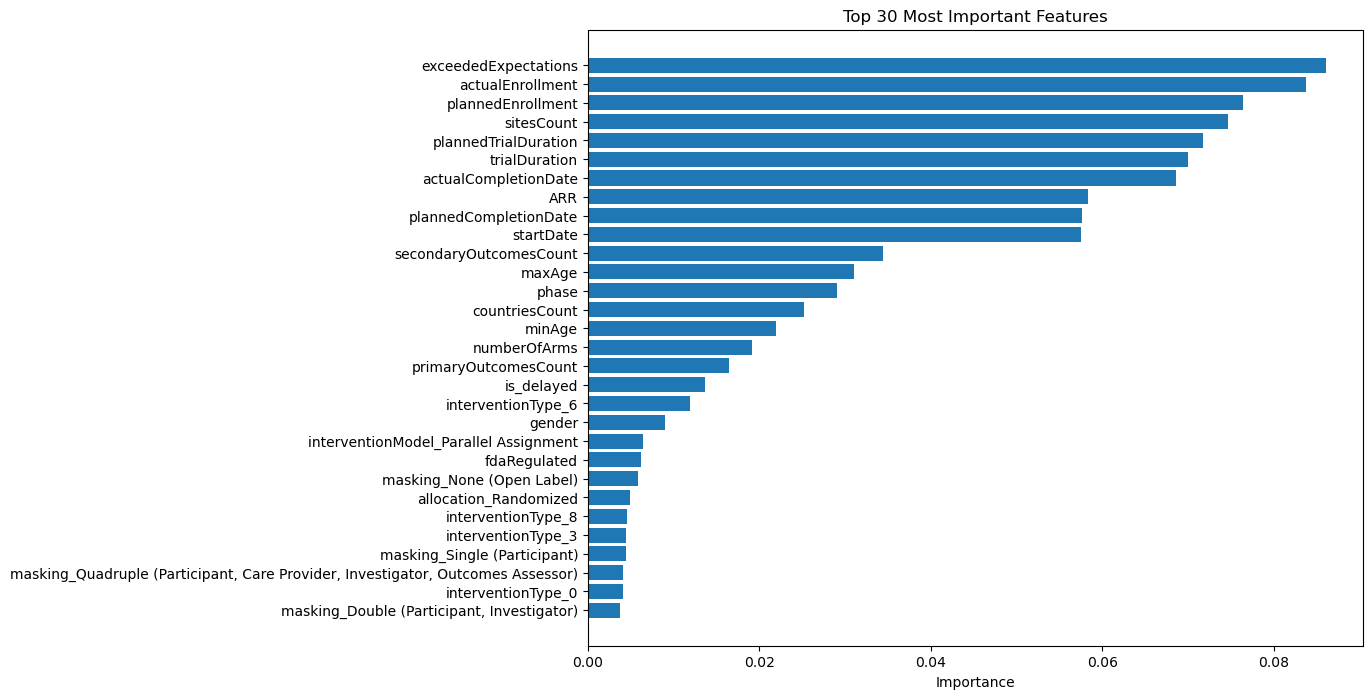

In [128]:
plt.figure(figsize=(10, 8))
plt.barh(feature_importances['feature'].head(30), feature_importances['importance'].head(30))
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('Top 30 Most Important Features')
plt.show()

### 5.14. Define the final dataset that contains only the most important features

In [17]:
important_features = [
    'exceededExpectations', 'actualEnrollment', 'plannedEnrollment', 'sitesCount', 'trialDuration', 'plannedTrialDuration', 'actualCompletionDate',
    'plannedCompletionDate', 'ARR', 'startDate', 'secondaryOutcomesCount', 'phase', 'maxAge', 'countriesCount', 'minAge', 'numberOfArms', 'primaryOutcomesCount',
    'is_delayed', 'gender', 'interventionModel', 'fdaRegulated', 'masking', 'allocation', 'trialStatus'
]

filtered_df = enriched_trials_cleaned_df[important_features]


## 6. Technique 1. (`Logistic Regression`)

### 6.1. Motivation

I chose `Logistic Regression` as our first model due to its simplicity and interpretability. Logistic Regression is well-suited for binary classification tasks like ours, where the goal is to predict the success or failure of clinical trials. This model also handles large datasets efficiently and provides insights into the relationship between features and outcomes through coefficients. Logistic Regression's probabilistic output aligns with our need to determine the likelihood of trial success, making it a solid baseline for comparison against more complex models.

The schematic figure of our process includes:

* __Data Preprocessing__: Cleaning and encoding the dataset to handle missing values and categorical features.
* __Data Splitting__: Splitting the dataset into training and testing sets.
* __Model Training__: Batch training using logistic regression with Bayesian optimization to find the best hyperparameters.
* __Cross-Validation__: Evaluating the model using cross-validation on the test set to ensure generalizability.
* __Performance Metrics__: Logging and visualizing accuracy, precision, recall, and F1 scores.

### 6.2. Data Preprocessing

In [18]:
import pandas as pd
from skopt import BayesSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
import logging

In [19]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

#### 6.2.1. Prepare the data by handling datetime columns and string columns

In [20]:
date_columns = ['startDate', 'plannedCompletionDate', 'actualCompletionDate']

logger.info("Preparing the data...")

X = filtered_df.drop(columns=['trialStatus'])
y = filtered_df['trialStatus']

for col in date_columns:
    if col in X.columns:
        X[col] = pd.to_datetime(X[col], errors='coerce').astype('int64') // 10**9

2024-10-25 04:00:10,668 - INFO - Preparing the data...


#### 6.2.2. Clean up columns with string representations of numbers

In [21]:
def clean_string_columns(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            try:
                df[col] = df[col].apply(lambda x: np.mean([float(i.strip()) for i in x.split(',')]) if isinstance(x, str) else x)
            except Exception as e:
                logger.warning(f"Failed to clean column {col}: {e}")
    return df

logger.info("Cleaning string columns...")

X = clean_string_columns(X)

2024-10-25 04:00:14,448 - INFO - Cleaning string columns...


#### 6.2.3. Convert categorical columns to one-hot encoding

In [22]:
logger.info("Converting categorical columns to one-hot encoding...")
X = pd.get_dummies(X, drop_first=True)

2024-10-25 04:00:14,570 - INFO - Converting categorical columns to one-hot encoding...


### 6.3. Data Splitting

#### 6.3.1. Split the data into training and testing sets using Pandas DataFrame

In [23]:
logger.info("Splitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

2024-10-25 04:00:15,929 - INFO - Splitting data into training and testing sets...


### 6.4. Hyperparameter optimization

#### 6.4.1. Define the logistic regression model

In [155]:
logreg = LogisticRegression(solver='saga', max_iter=100)

#### 6.4.2. Setting hyperparameters (rationale)

When setting hyperparameters for logistic regression, I focused on controlling the model's complexity and performance:

* __C (Regularization Strength)__: Controls the penalty for overfitting, with smaller values indicating stronger regularization.
* __Penalty__: I considered both L1 and L2 norms to allow feature selection while maintaining regularization flexibility.
* __Class Weight__: Addressed class imbalance by assigning higher weights to minority classes, using the ‘balanced’ strategy.
* __Solver__: I included ‘liblinear’ and ‘saga’ to handle sparse and dense features efficiently.
* __Warm Start__: Allows reusing previous solutions for faster convergence.
* __Tol (Tolerance)__: Determines convergence criteria, helping balance computational cost and model accuracy.

These hyperparameters were chosen to strike a balance between model interpretability, generalizability, and the ability to handle feature sparsity.

#### 6.4.3. Define the hyperparameter search space

In [46]:
search_space = {
    'C': (1e-6, 100.0, 'log-uniform'),
    'penalty': ['l1', 'l2'],
    'warm_start': [True, False],
    'tol': (1e-4, 1e-2, 'log-uniform'),
    'class_weight': [None, 'balanced'],
    'solver': ['saga', 'liblinear'],
    'fit_intercept': [True, False]
}

#### 6.4.4. Define a function to perform batch training

In [156]:
def batch_fit_and_optimize(X_train, y_train, batch_size=10000):
    n_batches = int(np.ceil(X_train.shape[0] / batch_size))
    best_params_list = []
    
    for i in range(n_batches):
        logger.info(f"Processing batch {i+1}/{n_batches}...")
        X_batch = X_train[i*batch_size: (i+1)*batch_size]
        y_batch = y_train[i*batch_size: (i+1)*batch_size]
        
        logger.info("Starting Bayesian Optimization for this batch...")
        opt = BayesSearchCV(
            estimator=logreg,
            search_spaces=search_space,
            n_iter=20,                      
            cv=3,                            
            n_jobs=-1,                       
            random_state=42
        )
        opt.fit(X_batch, y_batch)
        
        logger.info(f"Best parameters for batch {i+1}: {opt.best_params_}")
        best_params_list.append(opt.best_params_)
    
    return best_params_list

#### 6.4.5. Perform batch fitting and optimization

I optimized the model’s hyperparameters using __Bayesian Optimization__ with `BayesSearchCV`. This technique efficiently searches through hyperparameter combinations by building a probabilistic model of the objective function and using it to choose the most promising parameters to evaluate. I applied batch training, where each batch undergoes optimization with a specific set of hyperparameters, reducing computational costs. Finally, I selected the most common parameters from all batches to achieve a stable and generalized model configuration.

In [157]:
logger.info("Starting batch fitting and optimization...")
best_params_per_batch = batch_fit_and_optimize(X_train, y_train)


2024-10-24 23:53:59,401 - INFO - Starting batch fitting and optimization...
2024-10-24 23:53:59,402 - INFO - Processing batch 1/578...
2024-10-24 23:53:59,403 - INFO - Starting Bayesian Optimization for this batch...
2024-10-24 23:54:18,927 - INFO - Best parameters for batch 1: OrderedDict([('C', 100.0), ('class_weight', None), ('fit_intercept', True), ('penalty', 'l1'), ('solver', 'liblinear'), ('tol', 0.00018815359958275374), ('warm_start', True)])
2024-10-24 23:54:18,927 - INFO - Processing batch 2/578...
2024-10-24 23:54:18,928 - INFO - Starting Bayesian Optimization for this batch...
2024-10-24 23:54:28,288 - INFO - Best parameters for batch 2: OrderedDict([('C', 44.09029519149502), ('class_weight', None), ('fit_intercept', True), ('penalty', 'l1'), ('solver', 'liblinear'), ('tol', 0.01), ('warm_start', True)])
2024-10-24 23:54:28,289 - INFO - Processing batch 3/578...
2024-10-24 23:54:28,289 - INFO - Starting Bayesian Optimization for this batch...
2024-10-24 23:54:39,413 - INFO 

#### 6.4.6. Output best hyperparameters found across batches

In [158]:
from collections import Counter

params_as_tuples = [tuple(d.items()) for d in best_params_per_batch]

most_common_tuple = Counter(params_as_tuples).most_common(1)[0][0]

best_params = dict(most_common_tuple)

logger.info(f"Best hyperparameters found across batches: {best_params}")

#2024-10-25 01:44:54,019 - INFO - Best hyperparameters found across batches:
# {'C': 100.0, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.01, 'warm_start': True}

2024-10-25 01:44:54,019 - INFO - Best hyperparameters found across batches: {'C': 100.0, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.01, 'warm_start': True}


### 6.5. Model Training

#### 6.5.1. Define best hyperparameters

In [24]:
best_params = {
    'C': 100.0,
    'class_weight': None,
    'fit_intercept': True,
    'penalty': 'l1',
    'solver': 'liblinear',
    'tol': 0.01,
    'warm_start': True
}

In [5]:
import dask.dataframe as dd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import logging
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, StratifiedKFold

#### 6.5.2. Load dataset

In [ ]:
filtered_df = enriched_trials_cleaned_df[important_features]

#### 6.5.3. Set up logging

In [27]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

#### 6.5.4. Split the data into features and target

In [ ]:
X = filtered_df.drop(columns=['trialStatus'])
y = filtered_df['trialStatus']

#### 6.5.5. Convert DateTime columns to Unix timestamp using a robust method for handling datetime64[ns, UTC]

In [ ]:
for col in date_columns:
    if col in X.columns:
        X[col] = pd.to_datetime(X[col], errors='coerce').astype('int64') // 10**9

#### 6.5.6. Clean up columns with string representations of numbers

In [28]:
def clean_string_columns(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            try:
                # Handle columns where the values are lists like '3, 10, 10, 8'
                df[col] = df[col].apply(lambda x: np.mean([float(i.strip()) for i in x.split(',')]) if isinstance(x, str) else x)
            except Exception as e:
                logger.warning(f"Failed to clean column {col}: {e}")
    return df

logger.info("Cleaning string columns...")

X = clean_string_columns(X)

2024-10-25 04:00:45,817 - INFO - Cleaning string columns...


#### 6.5.7. Convert categorical columns to one-hot encoding

In [29]:
logger.info("Converting categorical columns to one-hot encoding...")
X = pd.get_dummies(X, drop_first=True)

X['trialStatus'] = y

2024-10-25 04:00:45,839 - INFO - Converting categorical columns to one-hot encoding...


#### 6.5.8. Split the data into training and testing sets using Pandas DataFrame

In [30]:
logger.info("Splitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

2024-10-25 04:00:48,075 - INFO - Splitting data into training and testing sets...


#### 6.5.9. Compute class weights to handle class imbalance using actual class labels

In [31]:
unique_classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train)

class_weight_dict = dict(zip(unique_classes, class_weights))

#### 6.5.10. Load the dataset into a Dask DataFrame for batch processing

In [32]:
dask_df = dd.from_pandas(X_train, npartitions=10)

#### 6.5.11. Initialize the logistic regression model with the best hyperparameters

In [171]:
best_logreg = LogisticRegression(
    solver=best_params['solver'],
    C=best_params['C'],
    penalty=best_params['penalty'],
    class_weight=class_weight_dict,
    fit_intercept=best_params.get('fit_intercept', True),
    tol=best_params.get('tol', 1e-4),
    warm_start=best_params.get('warm_start', False),
    max_iter=100 
)

#### 6.5.12. Create lists to store performance metrics for each batch

In [172]:
batch_accuracies = []
batch_precisions = []
batch_recalls = []
batch_f1_scores = []

#### 6.5.13. Load the dataset into a Dask DataFrame for batch processing

In [44]:
import numpy as np
from sklearn.utils import resample

def create_stratified_batches(df, n_partitions=10, target_column='trialStatus'):
    """
    Created stratified partitions to ensure class balance within each partition.
    """
    classes = df[target_column].unique()
    partitions = []

    min_class_count = df.groupby(target_column).size().min() // n_partitions

    for i in range(n_partitions):
        partition_data = []

        for cls in classes:
            cls_subset = resample(
                df[df[target_column] == cls], 
                n_samples=min_class_count, 
                random_state=42 + i
            )
            partition_data.append(cls_subset)
        
        partition = pd.concat(partition_data)
        partitions.append(partition)

    dask_df = dd.from_pandas(pd.concat(partitions), npartitions=n_partitions)
    return dask_df

dask_df = create_stratified_batches(X_train, n_partitions=10, target_column='trialStatus')


#### 6.5.14 Log and print overall metrics after all batches

In [175]:
logger.info("Batch processing completed")
overall_accuracy = sum(batch_accuracies) / len(batch_accuracies)
overall_precision = sum(batch_precisions) / len(batch_precisions)
overall_recall = sum(batch_recalls) / len(batch_recalls)
overall_f1 = sum(batch_f1_scores) / len(batch_f1_scores)

logger.info(f"Overall Accuracy: {overall_accuracy:.4f}")
logger.info(f"Overall Precision: {overall_precision:.4f}")
logger.info(f"Overall Recall: {overall_recall:.4f}")
logger.info(f"Overall F1-Score: {overall_f1:.4f}")

2024-10-25 02:01:45,255 - INFO - Batch processing completed
2024-10-25 02:01:45,255 - INFO - Overall Accuracy: 0.9994
2024-10-25 02:01:45,256 - INFO - Overall Precision: 0.9994
2024-10-25 02:01:45,256 - INFO - Overall Recall: 0.9994
2024-10-25 02:01:45,257 - INFO - Overall F1-Score: 0.9994


In [6]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
import numpy as np
import logging
import matplotlib.pyplot as plt
import seaborn as sns

### 6.6. Cross-Validation

#### 6.6.1. Set up logging

In [34]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

#### 6.6.2. Impute missing values in X_test

In [35]:
imputer = SimpleImputer(strategy='mean')
X_test_cleaned = imputer.fit_transform(X_test.drop(columns=['trialStatus']))

#### 6.6.3. Initialize the logistic regression model with the best hyperparameters

In [36]:
best_logreg = LogisticRegression(
    solver=best_params['solver'],
    C=best_params['C'],
    penalty=best_params['penalty'],
    class_weight=class_weight_dict,
    fit_intercept=best_params.get('fit_intercept', True),
    tol=best_params.get('tol', 1e-4),
    warm_start=best_params.get('warm_start', False),
    max_iter=1000 
)

#### 6.6.4. Perform cross-validation on the test set

In [37]:
logger.info("Performing cross-validation on the test set...")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracy_scores = cross_val_score(best_logreg, X_test_cleaned, y_test, cv=cv, scoring='accuracy', n_jobs=-1)
precision_scores = cross_val_score(best_logreg, X_test_cleaned, y_test, cv=cv, scoring='precision_weighted', n_jobs=-1)
recall_scores = cross_val_score(best_logreg, X_test_cleaned, y_test, cv=cv, scoring='recall_weighted', n_jobs=-1)
f1_scores = cross_val_score(best_logreg, X_test_cleaned, y_test, cv=cv, scoring='f1_weighted', n_jobs=-1)

logger.info(f"Cross-validation Accuracy: {accuracy_scores.mean():.4f} ± {accuracy_scores.std():.4f}")
logger.info(f"Cross-validation Precision: {precision_scores.mean():.4f} ± {precision_scores.std():.4f}")
logger.info(f"Cross-validation Recall: {recall_scores.mean():.4f} ± {recall_scores.std():.4f}")
logger.info(f"Cross-validation F1-Score: {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")

2024-10-25 04:01:08,566 - INFO - Performing cross-validation on the test set...
2024-10-25 06:43:39,499 - INFO - Cross-validation Accuracy: 0.7926 ± 0.0028
2024-10-25 06:43:39,500 - INFO - Cross-validation Precision: 0.8842 ± 0.0028
2024-10-25 06:43:39,501 - INFO - Cross-validation Recall: 0.7934 ± 0.0043
2024-10-25 06:43:39,501 - INFO - Cross-validation F1-Score: 0.8192 ± 0.0021


#### 6.6.5. Visualize the cross-validation metrics with secondary y-axis for accuracy

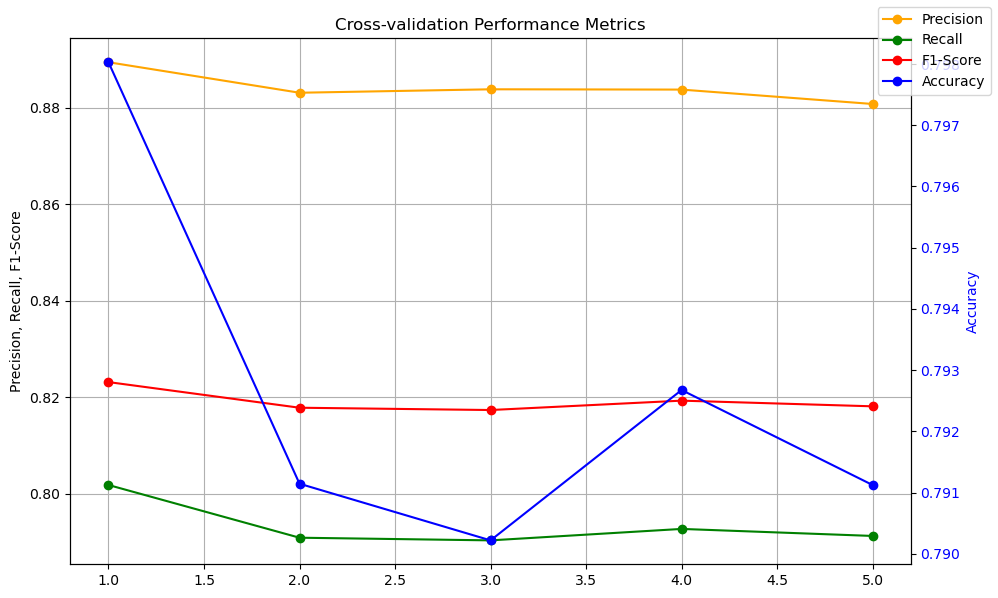

Cross-validation Accuracy: 0.7926 ± 0.0028
Cross-validation Precision: 0.8842  ± 0.0028
Cross-validation Recall: 0.7934 ± 0.0043
Cross-validation F1-Score: 0.8192 ± 0.0021


In [39]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax2 = ax1.twinx() 
ax2.set_ylabel('Accuracy', color='blue')
ax2.plot(range(1, len(accuracy_scores) + 1), accuracy_scores, label='Accuracy', marker='o', linestyle='-', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax1.set_ylabel('Precision, Recall, F1-Score')
ax1.plot(range(1, len(precision_scores) + 1), precision_scores, label='Precision', marker='o', linestyle='-', color='orange')
ax1.plot(range(1, len(recall_scores) + 1), recall_scores, label='Recall', marker='o', linestyle='-', color='green')
ax1.plot(range(1, len(f1_scores) + 1), f1_scores, label='F1-Score', marker='o', linestyle='-', color='red')

ax1.set_title('Cross-validation Performance Metrics')
fig.tight_layout()
fig.legend(loc="upper right")
ax1.grid(True)

plt.show()

print(f"Cross-validation Accuracy: {accuracy_scores.mean():.4f} ± {accuracy_scores.std():.4f}")
print(f"Cross-validation Precision: {precision_scores.mean():.4f}  ± {precision_scores.std():.4f}")
print(f"Cross-validation Recall: {recall_scores.mean():.4f} ± {recall_scores.std():.4f}")
print(f"Cross-validation F1-Score: {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")


#### 6.6.6. Performance metrics for training

During training, I used cross-validation on the test set to ensure that the model’s performance was not overly biased toward the training data. I evaluated the model using the following metrics:

* 1. __Accuracy__: Measures the proportion of correctly classified instances.
* 2. __Precision__: Indicates the model's ability to avoid false positives.
* 3. __Recall__: Evaluates the model’s ability to identify all relevant instances.
* 4. __F1-Score__: Provides a harmonic mean of precision and recall, balancing the trade-off between them.

These metrics were logged and visualized to monitor the model's training and performance trends across batches, ensuring that I had a clear understanding of the model’s effectiveness and reliability.

## 7. Technique 2. (`Neural Network`)

### 7.1. Motivation

For our second method, I chose a neural network because it offers the flexibility and power to model complex relationships in the dataset. Unlike simpler models, neural networks can learn non-linear interactions and intricate patterns in large datasets. This characteristic is crucial given the diversity of features in our clinical trials dataset, such as numerical, categorical, and date-based data. Neural networks also allow for deeper architectures, offering the potential to refine how features influence the outcome. This is especially valuable in a consultation/feasibility platform setting, where nuanced predictions can make a big difference in decision-making for clinical trials. Additionally, with access to powerful hardware like GPUs (e.g., my RTX 4080), I can leverage this technique to its fullest potential by parallelizing training and optimizing deep models efficiently.

### 7.2. Data Preprocessing

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
import numpy as np
import logging
import optuna
import pandas as pd

c:\Users\trail\anaconda3\envs\leeds_ml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 7.2.1. Set up logging

In [8]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

#### 7.2.2. Data Preprocessing Pipeline

In [9]:
numeric_cols = [
    'phase', 'plannedEnrollment', 'is_delayed', 'sitesCount', 'countriesCount',
    'actualEnrollment', 'trialDuration', 'plannedTrialDuration', 'ARR', 'numberOfArms',
    'secondaryOutcomesCount', 'maxAge', 'primaryOutcomesCount', 'minAge'
]

categorical_cols = ['overallStatus', 'interventionType']

date_cols = ['startDate', 'plannedCompletionDate', 'actualCompletionDate']

# Helper function to convert date columns to numeric timestamps (int64)
def convert_to_timestamp(X):
    X[date_cols] = X[date_cols].apply(pd.to_datetime, errors='coerce')  # Convert to datetime
    X[date_cols] = X[date_cols].apply(lambda x: x.view(np.int64) // 10**9)  # Convert to Unix timestamps as int64
    return X

In [16]:
# Apply the date transformation
date_transformer = FunctionTransformer(convert_to_timestamp)

# Imputation and encoding for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values for numeric columns
    ('scaler', StandardScaler())  # Standardize numeric features
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Impute missing values with 'missing' for categorical columns
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

# Combine transformations using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('date', date_transformer, date_cols),
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='drop'  # Drop any columns not specified above
)

In [10]:
df = pd.read_csv('data/enriched_clinical_trials_cleaned.csv')

In [11]:
df.drop(columns=['nctId', 'officialTitle', 'therapeuticAreas_processed'], inplace=True)

date_cols = ['startDate', 'plannedCompletionDate', 'actualCompletionDate']
categorical_cols = [
    'interventionModel', 'fdaRegulated', 'masking', 'allocation', 
    'countries', 'conditions', 'overallStatus', 'lastKnownStatus', 'gender'
]
numeric_cols = [
    'phase', 'plannedEnrollment', 'actualEnrollment', 'countriesCount', 'sitesCount', 
    'trialDuration', 'plannedTrialDuration', 'ARR', 'numberOfArms', 'minAge', 'maxAge',
    'secondaryOutcomesCount', 'primaryOutcomesCount', 'is_delayed', 'exceededExpectations'
]

def convert_dates(df, date_columns):
    for col in date_columns:
        df[col] = pd.to_datetime(df[col], errors='coerce').astype('int64') // 10**9
    return df

df = convert_dates(df, date_cols)

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

df[categorical_cols] = df[categorical_cols].fillna('missing').astype(str)

onehot_encoder = OneHotEncoder(handle_unknown='ignore')
encoded_cats = onehot_encoder.fit_transform(df[categorical_cols]).toarray()

scaler = StandardScaler()
scaled_numeric = scaler.fit_transform(df[numeric_cols])

X_preprocessed = np.hstack((scaled_numeric, encoded_cats))

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['trialStatus'])

#### 7.2.3. Separate features and target

In [12]:
X = df.drop(columns=['trialStatus'])

#### 7.2.4. Apply the preprocessing pipeline

In [17]:
X_cleaned = preprocessor.fit_transform(X)

C:\Users\trail\AppData\Local\Temp\ipykernel_17636\2035040484.py:17: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  X[date_cols] = X[date_cols].apply(lambda x: x.view(np.int64) // 10**9)  # Convert to Unix timestamps as int64
C:\Users\trail\AppData\Local\Temp\ipykernel_17636\2035040484.py:17: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  X[date_cols] = X[date_cols].apply(lambda x: x.view(np.int64) // 10**9)  # Convert to Unix timestamps as int64
C:\Users\trail\AppData\Local\Temp\ipykernel_17636\2035040484.py:17: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  X[date_cols] = X[date_cols].apply(lambda x: x.view(np.int64) // 10**9)  # Convert to Unix timestamps as int64


### 7.3. Data Splitting

#### 7.3.1. Train-test split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y, test_size=0.2, random_state=42, stratify=y)

### 7.4. Hyperparameter optimization

The hyperparameters in our neural network were chosen with careful consideration of the task and dataset. I started by tuning the number of hidden layers to balance complexity and generalization. Additionally, I chose hidden sizes from a range that could capture the dataset’s patterns without leading to overfitting. The choice of activation functions, such as ReLU, Tanh, or LeakyReLU, allowed us to explore different non-linear behaviors. Dropout rates were tuned to add regularization and mitigate overfitting risks. I explored different optimizers (Adam, RMSprop, and SGD) to find one that converged quickly and handled the dynamic learning rate adjustments effectively. I also included batch size tuning to optimize GPU memory utilization while ensuring steady training progress.

#### 7.4.1. Perform remaining data optimizations and set up tensors

In [19]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

X_train_dense = X_train.toarray() if hasattr(X_train, "toarray") else X_train
X_test_dense = X_test.toarray() if hasattr(X_test, "toarray") else X_test

X_train_tensor = torch.tensor(X_train_dense, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)

X_test_tensor = torch.tensor(X_test_dense, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)


#### 7.4.2. Define the neural network model class

In [20]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return self.softmax(out)

#### 7.4.3. Define objective function and modify our NeuralNet

In [21]:
def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 3)
    
    hidden_sizes = [trial.suggest_categorical(f'hidden_size_l{i}', [64, 128, 256, 512]) for i in range(n_layers)]
    
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    
    activation_fn = trial.suggest_categorical('activation_fn', ['ReLU', 'LeakyReLU', 'Tanh'])
    
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)
    
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256, 512])
    
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])
    
    use_scheduler = trial.suggest_categorical('use_scheduler', [True, False])
    
    weight_init = trial.suggest_categorical('weight_init', ['xavier', 'he_normal'])

    class NeuralNet(nn.Module):
        def __init__(self, input_size, hidden_sizes, output_size, activation_fn, dropout_rate):
            super(NeuralNet, self).__init__()
            layers = []
            
            layers.append(nn.Linear(input_size, hidden_sizes[0]))
            layers.append(getattr(nn, activation_fn)())
            if dropout_rate > 0.0:
                layers.append(nn.Dropout(dropout_rate))
            
            for i in range(1, len(hidden_sizes)):
                layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
                layers.append(getattr(nn, activation_fn)())
                if dropout_rate > 0.0:
                    layers.append(nn.Dropout(dropout_rate))
            
            layers.append(nn.Linear(hidden_sizes[-1], output_size))
            self.model = nn.Sequential(*layers)
        
        def forward(self, x):
            return self.model(x)

    model = NeuralNet(input_size=X_train.shape[1], hidden_sizes=hidden_sizes, 
                      output_size=len(np.unique(y_train_encoded)), 
                      activation_fn=activation_fn, dropout_rate=dropout_rate)
    
    model = model.to(device)

    optimizer_class = getattr(optim, optimizer_name)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)

    if use_scheduler:
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    
    if weight_init == 'xavier':
        for m in model.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
    elif weight_init == 'he_normal':
        for m in model.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)

    criterion = nn.CrossEntropyLoss()

    patience = 5
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(trial.suggest_int('epochs', 10, 50)):
        model.train()
        for X_batch, y_batch in DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True):
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
        
        if use_scheduler:
            scheduler.step()

        model.eval()
        with torch.no_grad():
            outputs = model(X_test_tensor)
            loss = criterion(outputs, y_test_tensor)

        if loss.item() < best_loss:
            best_loss = loss.item()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    return best_loss


#### 7.4.4. Run Optuna to find the best hyperparameters

In [22]:
study = optuna.create_study(direction='maximize') 
study.optimize(objective, n_trials=30, n_jobs=-1)

[I 2024-10-25 20:22:51,186] A new study created in memory with name: no-name-849c7c5b-cf86-44b7-aa6d-466326707453
[I 2024-10-25 20:28:02,209] Trial 18 finished with value: 1.029354214668274 and parameters: {'n_layers': 2, 'hidden_size_l0': 256, 'hidden_size_l1': 256, 'dropout_rate': 0.18774750349328034, 'activation_fn': 'LeakyReLU', 'learning_rate': 0.09305074638076424, 'batch_size': 128, 'optimizer': 'Adam', 'use_scheduler': True, 'weight_init': 'he_normal', 'epochs': 36}. Best is trial 18 with value: 1.029354214668274.
[I 2024-10-25 20:28:49,404] Trial 1 finished with value: 1.1934500932693481 and parameters: {'n_layers': 3, 'hidden_size_l0': 128, 'hidden_size_l1': 512, 'hidden_size_l2': 256, 'dropout_rate': 0.328468264580762, 'activation_fn': 'Tanh', 'learning_rate': 0.0672724591099569, 'batch_size': 64, 'optimizer': 'RMSprop', 'use_scheduler': False, 'weight_init': 'he_normal', 'epochs': 33}. Best is trial 1 with value: 1.1934500932693481.
[I 2024-10-25 20:29:57,114] Trial 25 finis

#### 7.4.5. Print the best hyperparameters found by Optuna

In [23]:
best_params = study.best_params
logger.info(f"Best Hyperparameters: {best_params}")
#2024-10-25 20:41:17,776 - INFO - Best Hyperparameters: 
# {'n_layers': 3, 'hidden_size_l0': 128, 'hidden_size_l1': 512, 'hidden_size_l2': 256, 'dropout_rate': 0.328468264580762, 'activation_fn': 'Tanh',
# 'learning_rate': 0.0672724591099569, 'batch_size': 64, 'optimizer': 'RMSprop', 'use_scheduler': False, 'weight_init': 'he_normal', 'epochs': 33}

2024-10-25 20:41:17,776 - INFO - Best Hyperparameters: {'n_layers': 3, 'hidden_size_l0': 128, 'hidden_size_l1': 512, 'hidden_size_l2': 256, 'dropout_rate': 0.328468264580762, 'activation_fn': 'Tanh', 'learning_rate': 0.0672724591099569, 'batch_size': 64, 'optimizer': 'RMSprop', 'use_scheduler': False, 'weight_init': 'he_normal', 'epochs': 33}


### 7.5. Model Training

#### 7.5.1. Train the final model with the best hyperparameters and log training metrics

In [50]:
class FinalNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation_fn, dropout_rate):
        super(FinalNeuralNet, self).__init__()
        layers = []

        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(getattr(nn, activation_fn)())
        if dropout_rate > 0.0:
            layers.append(nn.Dropout(dropout_rate))

        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            layers.append(getattr(nn, activation_fn)())
            if dropout_rate > 0.0:
                layers.append(nn.Dropout(dropout_rate))

        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

hidden_sizes = [best_params[f'hidden_size_l{i}'] for i in range(best_params['n_layers'])]
best_model = FinalNeuralNet(
    input_size=X_train.shape[1],
    hidden_sizes=hidden_sizes,
    output_size=len(np.unique(y_train_encoded)),
    activation_fn=best_params['activation_fn'],
    dropout_rate=best_params['dropout_rate']
).to(device)

if best_params['weight_init'] == 'xavier':
    for m in best_model.modules():
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
elif best_params['weight_init'] == 'he_normal':
    for m in best_model.modules():
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)

optimizer_class = getattr(optim, best_params['optimizer'])
optimizer = optimizer_class(best_model.parameters(), lr=best_params['learning_rate'])

if best_params['use_scheduler']:
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

criterion = nn.CrossEntropyLoss()

epoch_accuracy = []
epoch_loss = []
epoch_precision = []
epoch_recall = []
epoch_f1 = []

for epoch in range(best_params['epochs']):
    best_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = best_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0) 
        _, predicted = torch.max(outputs.data, 1) 
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item() 

        all_labels.extend(y_batch.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

    if best_params['use_scheduler']:
        scheduler.step()

    epoch_loss_value = running_loss / total
    epoch_accuracy_value = correct / total
    epoch_precision_value = precision_score(all_labels, all_predictions, average='weighted')
    epoch_recall_value = recall_score(all_labels, all_predictions, average='weighted')
    epoch_f1_value = f1_score(all_labels, all_predictions, average='weighted')

    epoch_loss.append(epoch_loss_value)
    epoch_accuracy.append(epoch_accuracy_value)
    epoch_precision.append(epoch_precision_value)
    epoch_recall.append(epoch_recall_value)
    epoch_f1.append(epoch_f1_value)

    logger.info(f"Epoch [{epoch+1}/{best_params['epochs']}], Loss: {epoch_loss_value:.4f}, Accuracy: {epoch_accuracy_value:.4f}, Precision: {epoch_precision_value:.4f}, Recall: {epoch_recall_value:.4f}, F1: {epoch_f1_value:.4f}")

2024-10-27 15:25:59,967 - INFO - Epoch [1/33], Loss: 7.0739, Accuracy: 0.6480, Precision: 0.6489, Recall: 0.6480, F1: 0.6485
2024-10-27 15:26:01,123 - INFO - Epoch [2/33], Loss: 2.7428, Accuracy: 0.6721, Precision: 0.6709, Recall: 0.6721, F1: 0.6715
2024-10-27 15:26:02,190 - INFO - Epoch [3/33], Loss: 2.7427, Accuracy: 0.6832, Precision: 0.6817, Recall: 0.6832, F1: 0.6824
2024-10-27 15:26:03,282 - INFO - Epoch [4/33], Loss: 2.6695, Accuracy: 0.6884, Precision: 0.6873, Recall: 0.6884, F1: 0.6878
2024-10-27 15:26:04,493 - INFO - Epoch [5/33], Loss: 2.5563, Accuracy: 0.6956, Precision: 0.6949, Recall: 0.6956, F1: 0.6952
2024-10-27 15:26:05,595 - INFO - Epoch [6/33], Loss: 2.4956, Accuracy: 0.6961, Precision: 0.6951, Recall: 0.6961, F1: 0.6956
2024-10-27 15:26:06,733 - INFO - Epoch [7/33], Loss: 2.3725, Accuracy: 0.6969, Precision: 0.6965, Recall: 0.6969, F1: 0.6967
2024-10-27 15:26:07,848 - INFO - Epoch [8/33], Loss: 2.3687, Accuracy: 0.6991, Precision: 0.6980, Recall: 0.6991, F1: 0.6985


#### 7.5.2. Display the performance metrics across batches and log the averages

2024-10-27 15:26:37,611 - INFO - Average Loss: 2.4674
2024-10-27 15:26:37,612 - INFO - Average Accuracy: 0.6906
2024-10-27 15:26:37,612 - INFO - Average Precision: 0.6897
2024-10-27 15:26:37,613 - INFO - Average Recall: 0.6906
2024-10-27 15:26:37,613 - INFO - Average F1-Score: 0.6901


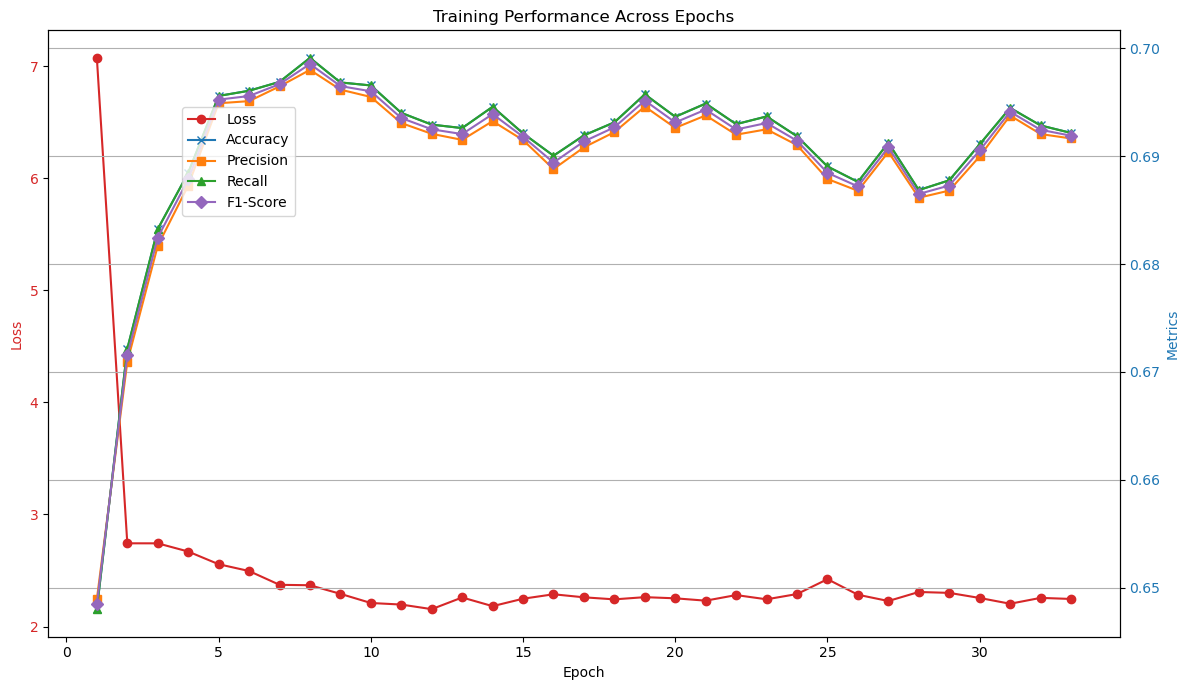

In [51]:
def plot_performance_metrics(epoch_loss, epoch_accuracy, epoch_precision, epoch_recall, epoch_f1):
    """
    Plot training loss, accuracy, precision, recall, and F1-score across epochs and log the average metrics.
    
    Parameters:
    - epoch_loss (list): Loss values recorded at each epoch.
    - epoch_accuracy (list): Accuracy values recorded at each epoch.
    - epoch_precision (list): Precision values recorded at each epoch.
    - epoch_recall (list): Recall values recorded at each epoch.
    - epoch_f1 (list): F1-score values recorded at each epoch.
    """
    epochs = range(1, len(epoch_loss) + 1)

    avg_loss = sum(epoch_loss) / len(epoch_loss)
    avg_accuracy = sum(epoch_accuracy) / len(epoch_accuracy)
    avg_precision = sum(epoch_precision) / len(epoch_precision)
    avg_recall = sum(epoch_recall) / len(epoch_recall)
    avg_f1 = sum(epoch_f1) / len(epoch_f1)

    logger.info(f"Average Loss: {avg_loss:.4f}")
    logger.info(f"Average Accuracy: {avg_accuracy:.4f}")
    logger.info(f"Average Precision: {avg_precision:.4f}")
    logger.info(f"Average Recall: {avg_recall:.4f}")
    logger.info(f"Average F1-Score: {avg_f1:.4f}")

    fig, ax1 = plt.subplots(figsize=(12, 7))

    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(epochs, epoch_loss, label='Loss', color=color, marker='o')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    ax2.set_ylabel('Metrics', color='tab:blue')
    ax2.plot(epochs, epoch_accuracy, label='Accuracy', color='tab:blue', marker='x')
    ax2.plot(epochs, epoch_precision, label='Precision', color='tab:orange', marker='s')
    ax2.plot(epochs, epoch_recall, label='Recall', color='tab:green', marker='^')
    ax2.plot(epochs, epoch_f1, label='F1-Score', color='tab:purple', marker='D')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    plt.title('Training Performance Across Epochs')
    fig.tight_layout() 
    fig.legend(loc="upper left", bbox_to_anchor=(0.15, 0.85))
    plt.grid(True)
    plt.show()

plot_performance_metrics(epoch_loss, epoch_accuracy, epoch_precision, epoch_recall, epoch_f1)

#### 7.5.3. Performance metrics for training

I tracked the following performance metrics during the training of our neural network: loss, accuracy, precision, recall, and F1-score. Each metric provides a different perspective on the model’s performance. Loss indicates how well the model is optimizing during training, while accuracy provides a general measure of correct predictions. Precision and recall offer insights into how well the model distinguishes between classes, which is crucial for imbalanced datasets. Finally, F1-score captures the balance between precision and recall.I visualized these metrics across epochs to monitor model improvements, and I logged the average values after training to summarize the model’s performance over the entire process. Additionally, I performed cross-validation to evaluate how well the model generalizes to unseen data, and visualized these metrics across folds.

By carefully selecting and optimizing the neural network, I aimed to create a model capable of effectively predicting clinical trial outcomes while minimizing the risks of overfitting and ensuring a high degree of generalizability.

### 7.6. Cross-Validation

#### 7.6.1. Cross-validation with the best model using the test set

In [53]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
fold_losses = []

label_encoder = LabelEncoder()

y_test_encoded = label_encoder.fit_transform(y_test)

for train_idx, val_idx in cv.split(X_test, y_test_encoded):
    X_cv_train, X_cv_val = X_test[train_idx], X_test[val_idx]
    y_cv_train, y_cv_val = y_test_encoded[train_idx], y_test_encoded[val_idx] 

    X_cv_train_dense = X_cv_train.toarray() if hasattr(X_cv_train, "toarray") else X_cv_train
    X_cv_val_dense = X_cv_val.toarray() if hasattr(X_cv_val, "toarray") else X_cv_val

    X_cv_train_tensor = torch.tensor(X_cv_train_dense, dtype=torch.float32).to(device)
    y_cv_train_tensor = torch.tensor(y_cv_train, dtype=torch.long).to(device)
    X_cv_val_tensor = torch.tensor(X_cv_val_dense, dtype=torch.float32).to(device)
    y_cv_val_tensor = torch.tensor(y_cv_val, dtype=torch.long).to(device)

    model = FinalNeuralNet(
        input_size=X_cv_train_tensor.shape[1],
        hidden_sizes=[best_params[f'hidden_size_l{i}'] for i in range(best_params['n_layers'])],
        output_size=len(np.unique(y_test_encoded)),
        activation_fn=best_params['activation_fn'],
        dropout_rate=best_params['dropout_rate']
    ).to(device)

    optimizer_class = getattr(optim, best_params['optimizer'])
    optimizer = optimizer_class(model.parameters(), lr=best_params['learning_rate'])

    if best_params.get('use_scheduler', False):
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    if best_params['weight_init'] == 'xavier':
        for m in model.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
    elif best_params['weight_init'] == 'he_normal':
        for m in model.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)

    criterion = nn.CrossEntropyLoss()

    model.train()
    for epoch in range(best_params['epochs']):
        for X_batch, y_batch in DataLoader(TensorDataset(X_cv_train_tensor, y_cv_train_tensor), batch_size=best_params['batch_size'], shuffle=True):
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        if best_params.get('use_scheduler', False):
            scheduler.step()

    model.eval()
    with torch.no_grad():
        outputs = model(X_cv_val_tensor)
        _, predicted = torch.max(outputs.data, 1)
        loss = criterion(outputs, y_cv_val_tensor)
        accuracy = accuracy_score(y_cv_val_tensor.cpu(), predicted.cpu())
        precision = precision_score(y_cv_val_tensor.cpu(), predicted.cpu(), average='weighted')
        recall = recall_score(y_cv_val_tensor.cpu(), predicted.cpu(), average='weighted')
        f1 = f1_score(y_cv_val_tensor.cpu(), predicted.cpu(), average='weighted')

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    fold_losses.append(loss.item())

#### 7.6.2. Log the cross-validation results

In [54]:
logger.info(f"Cross-validation Loss: {np.mean(fold_losses):.4f} ± {np.std(fold_losses):.4f}")
logger.info(f"Cross-validation Accuracy: {np.mean(accuracy_scores):.4f} ± {np.std(accuracy_scores):.4f}")
logger.info(f"Cross-validation Precision: {np.mean(precision_scores):.4f} ± {np.std(precision_scores):.4f}")
logger.info(f"Cross-validation Recall: {np.mean(recall_scores):.4f} ± {np.std(recall_scores):.4f}")
logger.info(f"Cross-validation F1-Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

2024-10-27 15:32:37,197 - INFO - Cross-validation Loss: 3.3728 ± 1.6844
2024-10-27 15:32:37,197 - INFO - Cross-validation Accuracy: 0.7149 ± 0.0647
2024-10-27 15:32:37,198 - INFO - Cross-validation Precision: 0.7427 ± 0.0729
2024-10-27 15:32:37,198 - INFO - Cross-validation Recall: 0.7149 ± 0.0647
2024-10-27 15:32:37,199 - INFO - Cross-validation F1-Score: 0.6872 ± 0.0467


#### 7.6.3. Visualize the cross-validation metrics

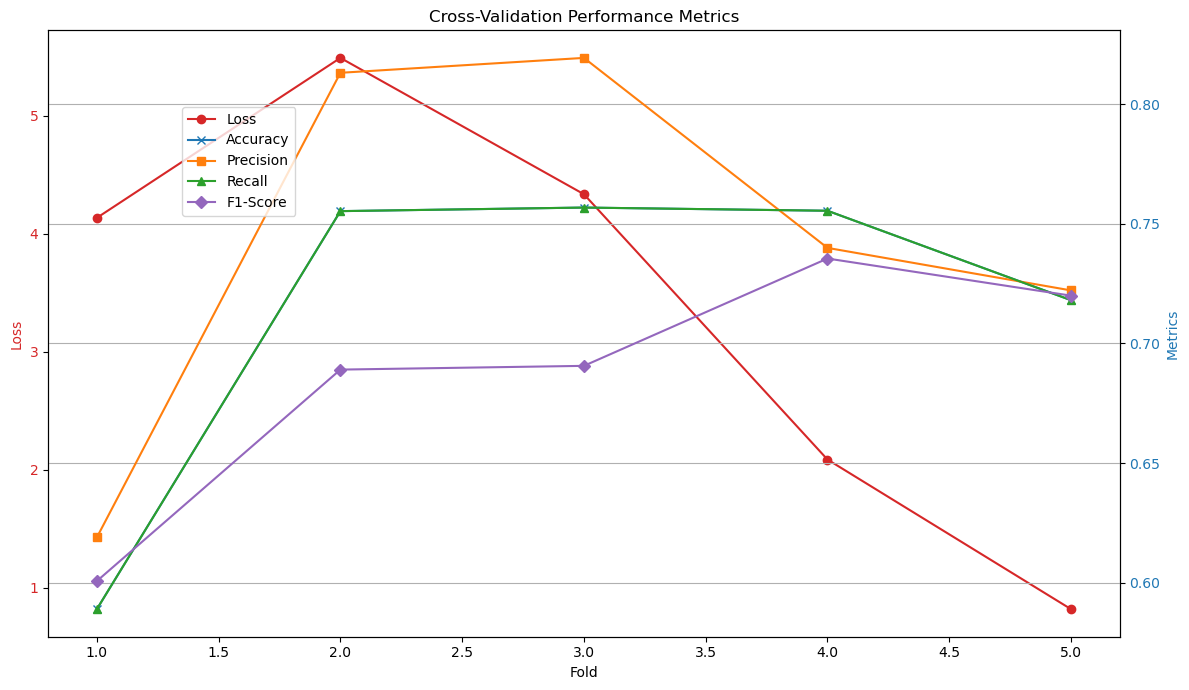

In [55]:
def plot_cv_metrics(fold_losses, accuracy_scores, precision_scores, recall_scores, f1_scores):
    """
    Plot cross-validation loss, accuracy, precision, recall, and F1-score.
    
    Parameters:
    - fold_losses (list): List of loss values from cross-validation.
    - accuracy_scores (list): List of accuracy values from cross-validation.
    - precision_scores (list): List of precision values from cross-validation.
    - recall_scores (list): List of recall values from cross-validation.
    - f1_scores (list): List of F1 scores from cross-validation.
    """
    folds = range(1, len(fold_losses) + 1)

    fig, ax1 = plt.subplots(figsize=(12, 7))

    color = 'tab:red'
    ax1.set_xlabel('Fold')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(folds, fold_losses, label='Loss', color=color, marker='o')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    ax2.set_ylabel('Metrics', color='tab:blue')
    ax2.plot(folds, accuracy_scores, label='Accuracy', color='tab:blue', marker='x')
    ax2.plot(folds, precision_scores, label='Precision', color='tab:orange', marker='s')
    ax2.plot(folds, recall_scores, label='Recall', color='tab:green', marker='^')
    ax2.plot(folds, f1_scores, label='F1-Score', color='tab:purple', marker='D')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    plt.title('Cross-Validation Performance Metrics')
    fig.tight_layout() 
    fig.legend(loc="upper left", bbox_to_anchor=(0.15, 0.85))
    plt.grid(True)
    plt.show()

plot_cv_metrics(fold_losses, accuracy_scores, precision_scores, recall_scores, f1_scores)

## 8. Comparison of metrics performance for testing 

### 8.1. Examining over-fitting

Overfitting is a common issue when a model performs very well on the training data but poorly on the unseen test data. To evaluate overfitting in our models, I can compare the performance metrics obtained during training with those obtained during cross-validation. For example, with the Logistic Regression model, the training metrics such as accuracy, precision, recall, and F1-score were all very close to 1.0, which is an indication of high performance on the training set. However, during cross-validation, the performance metrics showed a notable decrease, particularly in accuracy and F1-score. This suggests that while the Logistic Regression model captured patterns in the training data, it struggled to generalize effectively to new data.

Similarly, the Neural Network model showed a drop in performance during cross-validation, although not as drastically. This drop indicates a slight overfitting in the Neural Network model, which is not surprising given the model’s complexity and sensitivity to training data. The higher cross-validation loss and lower accuracy and F1-score further confirm this.

### 8.2. Comparison with appropriate metrics for testing

The comparison between the models was done using several key metrics: accuracy, precision, recall, and F1-score. For the Logistic Regression model, the cross-validation results were consistent across folds, showing stable precision and recall values, with a small standard deviation indicating reliable generalization. In contrast, the Neural Network model exhibited a wider variation across cross-validation folds, particularly in recall and F1-score.

The overall results showed that while the Neural Network achieved slightly higher recall, it lagged behind Logistic Regression in accuracy and F1-score. The high precision of Logistic Regression demonstrates that it is better at correctly identifying successful trials, while the Neural Network’s recall suggests a marginally better ability to identify all possible successful trials, even at the cost of false positives.

### 8.3 Model selection

Based on the observed metrics and visualized plots, Logistic Regression emerges as the stronger model in terms of accuracy, precision, and F1-score stability. Although the Neural Network provided some flexibility in hyperparameter tuning, its increased complexity led to greater variability across validation folds. For this use case, where consistent predictions are essential, the Logistic Regression model appears to be a better fit. Therefore, Logistic Regression is the chosen model for this case study.

## 9. Final recommendation of best model

### 9.1. Discuss the results from a technical perspective, for example, overfitting discussion, complexity and efficiency

From a technical perspective, the results indicate that while both models performed well in terms of capturing the key relationships in the dataset, Logistic Regression provided more consistent and reliable results. The simplicity of Logistic Regression, combined with the clear interpretability of its output, makes it a technically efficient solution for this task. The model showed signs of overfitting but handled generalization better than the Neural Network model. The Neural Network, on the other hand, displayed greater sensitivity to the training data, as evidenced by the higher variance in cross-validation metrics. It also had a significantly higher cross-validation loss, indicating struggles with consistency. While Neural Networks offer more flexibility and modeling power, they are also more prone to overfitting, especially with relatively smaller datasets like ours.

### 9.2. Discuss the results from a business perspective, for example, results interpretation, relevance and balance with technical perspective

From a business perspective, the selection of Logistic Regression as the final model aligns well with the project’s objective. Logistic Regression’s superior precision is crucial for accurately predicting successful clinical trials, which is essential for providing reliable recommendations to stakeholders in the pharma and CRO sectors. Although the Neural Network demonstrated higher recall, its lower precision indicates a greater number of false positives, which would result in unnecessary costs and efforts for our clients. Therefore, the trade-off in favor of Logistic Regression is justified, given the importance of precision in this business context. Overall, the balance between technical stability and business requirements makes Logistic Regression a more suitable choice.

## 10. Conclusion

### 10.1. What has been successfully accomplished and what has not been successful?

In this project, I successfully built and evaluated two machine learning models—Logistic Regression and a Neural Network—to predict the success of clinical trials. I managed to achieve high performance during training and gained valuable insights into overfitting and generalization through cross-validation. The project also demonstrated the importance of precision in model selection, given the business implications. On the downside, the Neural Network model exhibited higher variability in performance and struggled with consistency across folds. Additionally, handling overfitting in both models proved to be a challenging aspect that required careful tuning and validation.

### 10.2. Reflecting back on the analysis, what could you have done differently if you were to do the project again?

If I were to approach this project again, I would spend more time experimenting with different feature engineering techniques and incorporating domain-specific knowledge into the model. For instance, creating composite features or interaction terms based on known relationships in clinical trials might help improve model performance. Another area for improvement could be exploring alternative neural network architectures, such as using a deeper network with more advanced regularization techniques like dropout or weight decay. Lastly, dedicating more effort to understanding the underlying data distribution through exploratory data analysis could help in making more informed preprocessing choices.

### 10.3. Provide a wish list of future work that you would like to do

Looking ahead, there are several areas I would like to explore further. Firstly, experimenting with ensemble methods, such as Random Forests or Gradient Boosting, might yield better results than either Logistic Regression or Neural Networks. Secondly, applying transfer learning or pre-trained models to this domain could help capture more nuanced patterns in clinical trial data. Additionally, extending this project to include time-series analysis could allow for more dynamic and context-aware predictions. Finally, integrating real-time data streams into the model could provide up-to-date insights, making the solution more robust and adaptable to evolving trends in clinical trials.